In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import datetime
import seaborn as sns
import re
from shapely.geometry import Point, Polygon, MultiPolygon
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import os
from scipy.integrate import solve_ivp
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import string
import matplotlib.gridspec as gridspec # gridspec 모듈 임포트

# Set seed
np.random.seed(250121)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['font.family']='Arial'

bar_width=0.25
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('legend', fontsize=10)
plt.rc('figure', titlesize=12) 
# dateFmt = mdates.DateFormatter('%Y-%m-%d')
alphsize=12
alpha=0.4
padsize=15
set_dpi=300

In [ ]:
## save folder name
rawdatafolder='../../Data/covariate_step2/'
datafolder="../../Data/delta_scenario/"
inputfolder='../../Result/delta/'
figurefolder = "../../Figure/delta_scenario/JMV_final/"
project_path = "../Monolix_fitting_Kim/Variant_step2/delta_scenario/"


## Fig 2.

In [5]:
timeVL = np.arange(0, 30.1, 0.1)

In [6]:
delta_indivl = pd.read_csv(rawdatafolder + 'ct_data_d.csv')

In [7]:
delta_popfit = pd.read_csv(inputfolder + 'NBA_Delta_population_fit.csv')
delta_popfit

Unnamed: 0   time        VL      lower     upper
0              1   0.00 -2.000000  -2.000000 -2.000000
1              2   0.01 -1.959125  -1.986278 -1.903787
2              3   0.02 -1.918250  -1.972557 -1.807574
3              4   0.03 -1.877374  -1.958835 -1.711361
4              5   0.04 -1.836499  -1.945114 -1.615147
...          ...    ...       ...        ...       ...
2996        2997  29.96 -7.292409 -19.392996  0.543056
2997        2998  29.97 -7.298103 -19.402660  0.539656
2998        2999  29.98 -7.303796 -19.412323  0.536257
2999        3000  29.99 -7.309490 -19.421987  0.532857
3000        3001  30.00 -7.315184 -19.431650  0.529457

[3001 rows x 5 columns]

In [8]:
color_list=['#3772ff','#f28482']

In [9]:
gs=[0]*1
ax=[0]*1

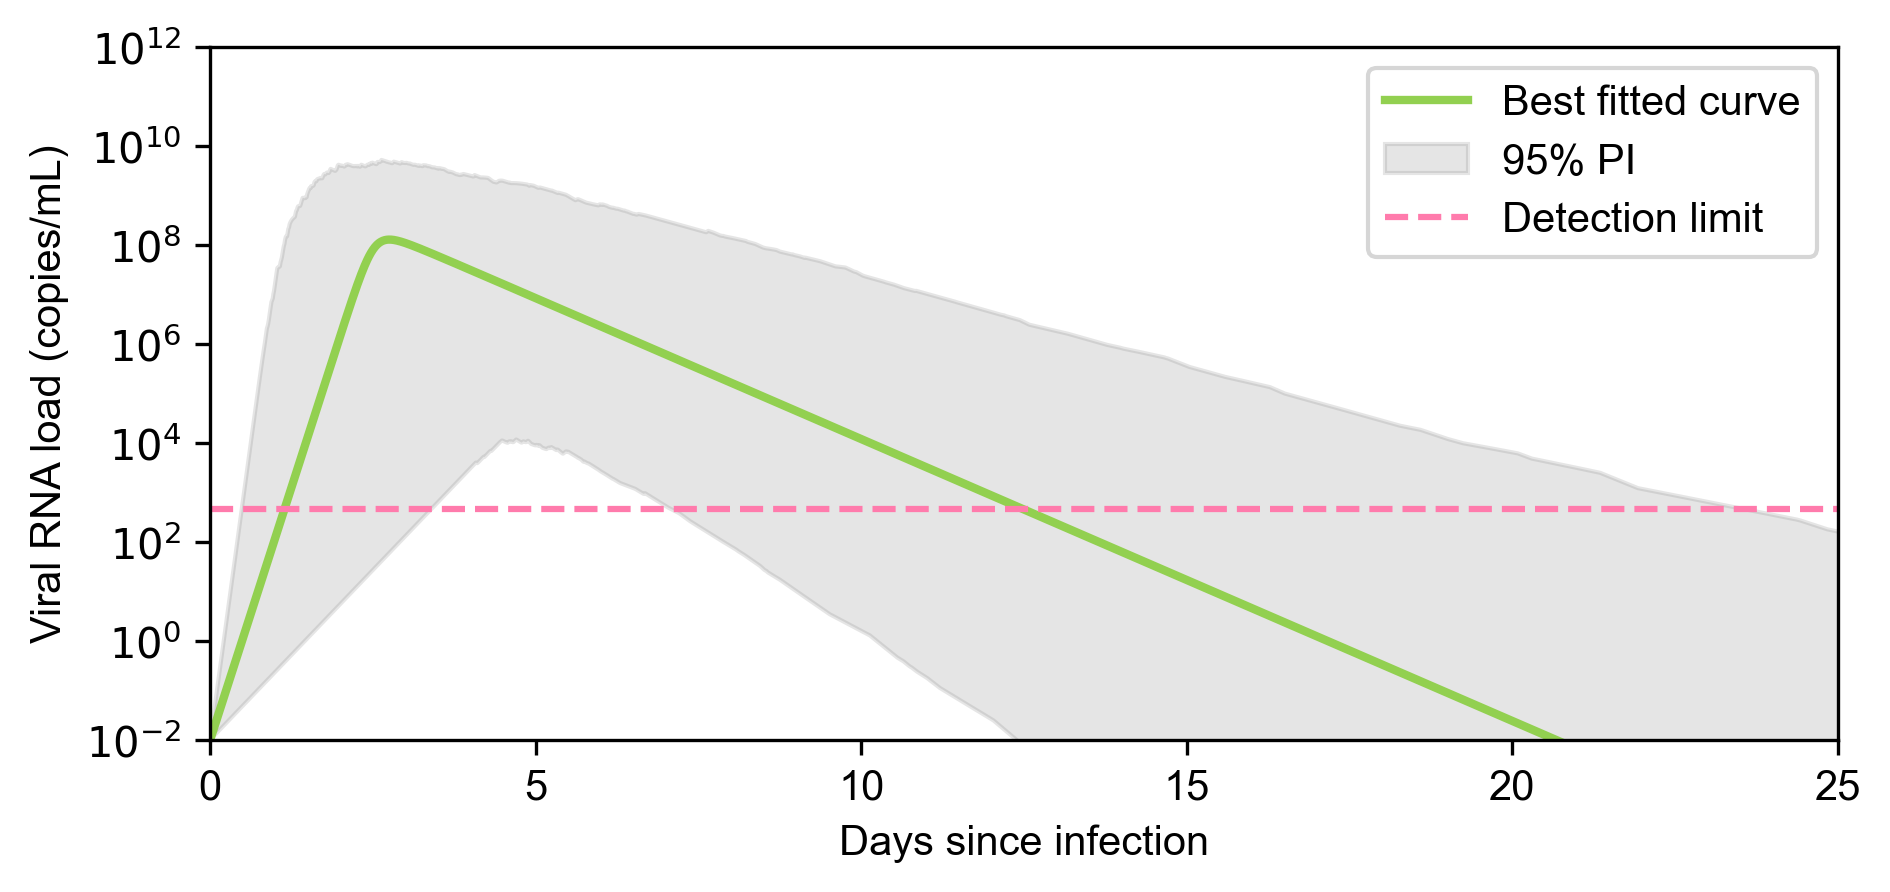

In [ ]:
fig=plt.figure(figsize=(7,3),dpi=set_dpi)

gs[0]=fig.add_gridspec()

i = 0
ax[i] = fig.add_subplot(gs[i][0])
ax[i].plot(delta_popfit['time'], delta_popfit['VL'], color="#92D050", label='Best fitted curve', lw=2)
ax[i].fill_between(delta_popfit['time'], delta_popfit['lower'], delta_popfit['upper'], color='gray', alpha=0.2, label='95% PI')
ax[i].axhline(y=2.656, color='#FF7BAC', linestyle='--', lw=1.5, label='Detection limit')
ax[i].set_ylabel('Viral RNA load (copies/mL)')
ax[i].set_xlabel('Days since infection')
ax[i].set_xlim(0, 25)
ax[i].set_xticks(np.arange(0, 25+1, 5))
ax[i].set_ylim(-2,12)
ax[i].set_yticks(np.arange(-2, 13, 2))
ax[i].set_yticklabels([r'$10^{-2}$', r'$10^0$', r'$10^2$', r'$10^4$', r'$10^6$', r'$10^8$', r'$10^{10}$', r'$10^{12}$'])
ax[i].margins(x=0)
ax[i].grid(False)
ax[i].legend(loc='upper right', fontsize=10)

plt.show()
# fig.savefig(figurefolder+'Fig2.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# fig.savefig(figurefolder+'Fig2.png', format='png', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)


## Fig 3.

In [11]:
# Basic settings
alpha = 0.05  # Statistical significance level
N = 10000      # The number of ground truth VL (individuals)
min_time, max_time, time_interval = 0, 30, 0.01
times = np.arange(min_time, max_time + time_interval, time_interval)
detection_limit = (40 - 49.5932) / (-3.6097)  # Threshold: detection limit (log10 form)

# Scenario settings
S_list = [3]
M_list = [1, 2, 3, 4, 5, 8]
N_test_list = [200, 500, 1000]
variant = "delta"
K = 100

In [12]:
def parameter_confidence_intervals(population_parameters):
    population_parameters = population_parameters.copy()
    population_parameters['se_trans'] = np.where(
        population_parameters.index.str.endswith("_pop") |
        population_parameters.index.str.startswith("omega_"),
        np.sqrt(np.log((1 + np.sqrt(1 + (2 * population_parameters['se_sa'] / population_parameters['value'])**2)) / 2)),
        np.nan
    )
    population_parameters['lower'] = np.where(
        population_parameters.index.str.endswith("_pop") |
        population_parameters.index.str.startswith("omega_"),
        np.exp(np.log(population_parameters['value']) + np.quantile(np.random.normal(0, 1, 10000), alpha / 2) * population_parameters['se_trans']),
        population_parameters['value'] + np.quantile(np.random.normal(0, 1, 10000), alpha / 2) * population_parameters['se_sa']
    )
    population_parameters['upper'] = np.where(
        population_parameters.index.str.endswith("_pop") |
        population_parameters.index.str.startswith("omega_"),
        np.exp(np.log(population_parameters['value']) + np.quantile(np.random.normal(0, 1, 10000), 1 - (alpha / 2)) * population_parameters['se_trans']),
        population_parameters['value'] + np.quantile(np.random.normal(0, 1, 10000), 1 - (alpha / 2)) * population_parameters['se_sa']
    )
    return population_parameters

def get_predicted_parameters(population_parameters):
    params = {param: population_parameters.loc[param, 'value'] if param in population_parameters.index else 0
              for param in ["gamma_pop", "beta1_pop", "delta_pop", "tau_pop"]}
    params['beta1_pop'] = params['beta1_pop'] * 1e-5
    return params

def covfun2(t, y, pars):
    f, V = y
    beta, gamma, delta = pars['beta1_pop'], pars['gamma_pop'], pars['delta_pop']
    dfdt = -beta * f * V
    dVdt = gamma * f * V - delta * V
    return [dfdt, dVdt]


def esti_vl(params):
    solution = solve_ivp(
        covfun2, [0, max_time], [1, 0.01], t_eval=times, args=(params,),
        rtol=0.00004, atol=1e-12
    )
    return pd.DataFrame({"time": solution.t, "aV": np.log10(solution.y[1])})


In [ ]:
S_list = [3]
M_list = [1, 2, 3]
N_test_list = [200, 500, 1000]

sim_data_temp = [] ; VL = []

VL_list = [[[[] for _ in S_list] for _ in M_list] for _ in N_test_list]
sim_data_list = [[[[] for _ in S_list] for _ in M_list] for _ in N_test_list]

for n_idx, N_test in enumerate(N_test_list):
    for m_idx, M in enumerate(M_list):
        for s_idx, S in enumerate(S_list):
            VL = []
            N_partici = N_test // M
            
            for i in range(1, K + 1):
                sim_pop = pd.read_csv(f"{project_path}{N_test}obsdata_N_{N_partici}_M_{M}_S_{S}_{i}/populationParameters.txt", sep=",", index_col=0)
                sim_data = pd.read_csv(f"{datafolder}{N_test}obsdata_N_{N_partici}_M_{M}_S_{S}_{i}.csv")
                sim_data_temp.append(sim_data)
                sim_pop_params = parameter_confidence_intervals(sim_pop)
                pred_sim_pop_params = get_predicted_parameters(sim_pop_params)
                
                fit = esti_vl(pred_sim_pop_params)
                VL.append(fit)
            
            VL_list[n_idx][m_idx][s_idx] = VL
            sim_data_list[n_idx][m_idx][s_idx] = sim_data_temp

In [14]:
color_list = ["#00A087", "#FFC000"]

In [15]:
ax=[0]*9
gs=[0]*9

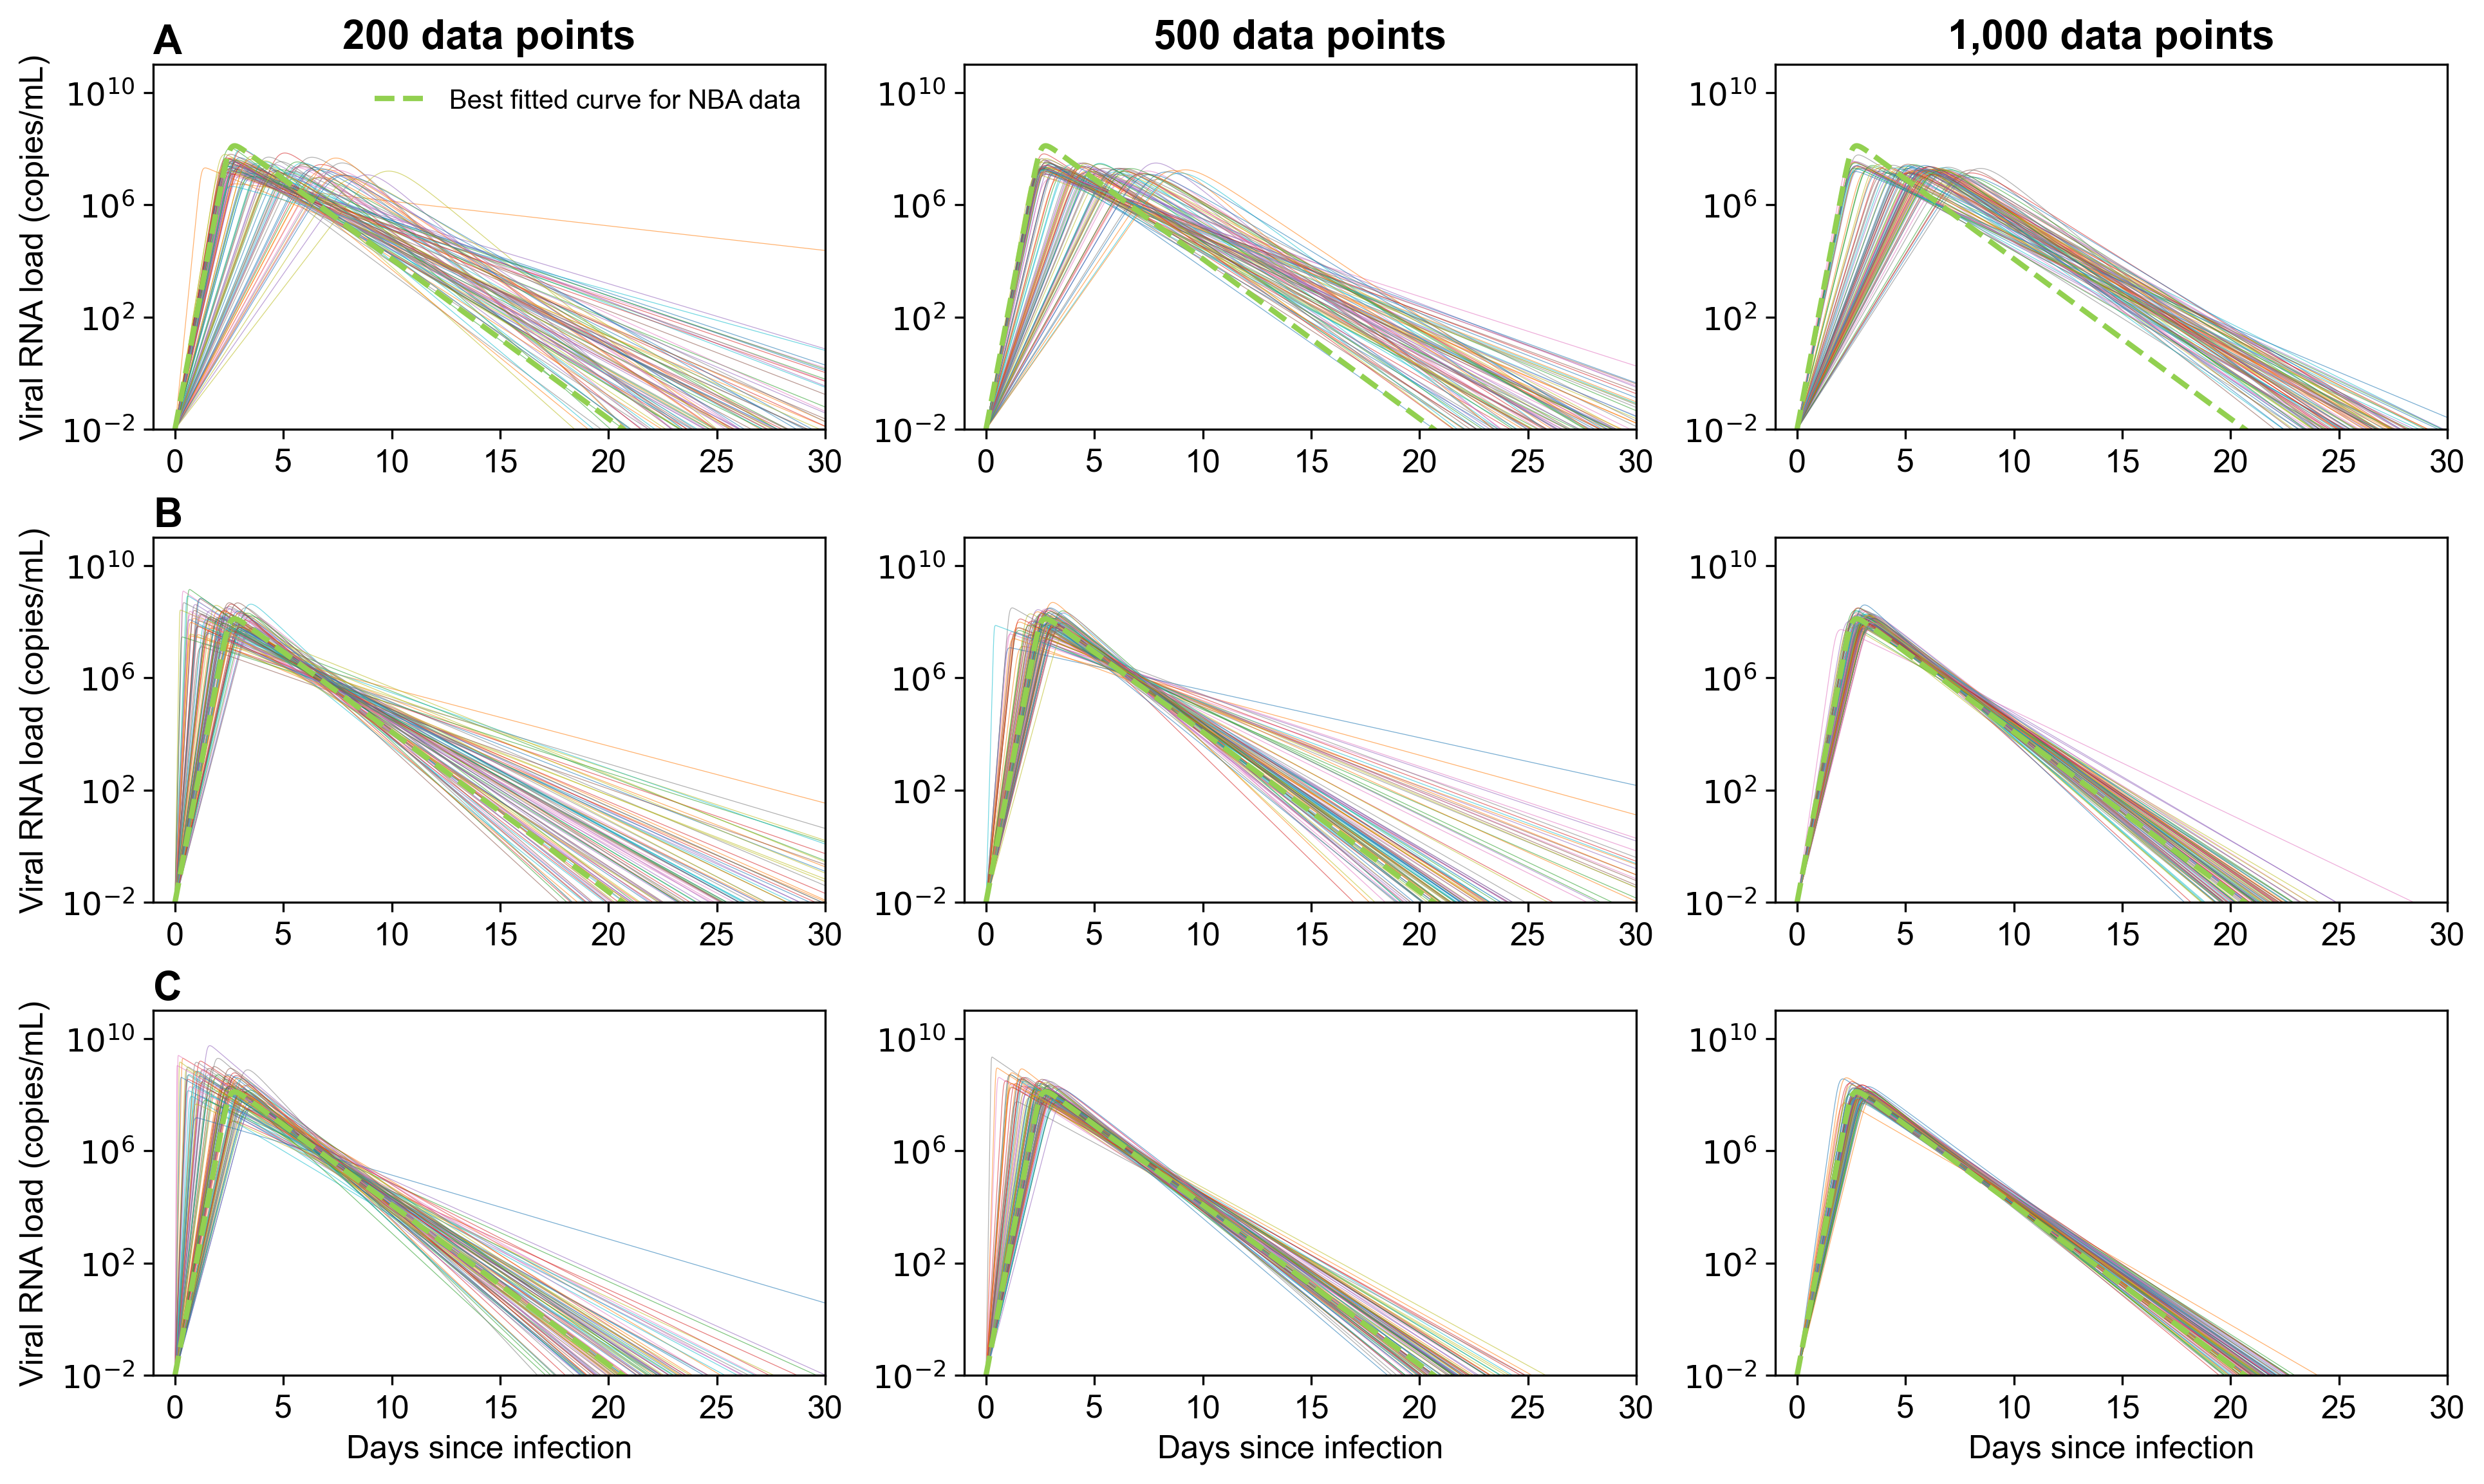

In [ ]:
## 200, 500, 1000

fig=plt.figure(figsize=(12,7),dpi=set_dpi)

gs[0]=fig.add_gridspec(nrows=1,ncols=1,top=0.97, bottom=0.70, left=0, right=0.29)
gs[1]=fig.add_gridspec(nrows=1,ncols=1,top=0.97, bottom=0.70, left=0.35, right=0.64)
gs[2]=fig.add_gridspec(nrows=1,ncols=1,top=0.97, bottom=0.70, left=0.7, right=0.99)
gs[3]=fig.add_gridspec(nrows=1,ncols=1,top=0.62, bottom=0.35, left=0, right=0.29)
gs[4]=fig.add_gridspec(nrows=1,ncols=1,top=0.62, bottom=0.35, left=0.35, right=0.64)
gs[5]=fig.add_gridspec(nrows=1,ncols=1,top=0.62, bottom=0.35, left=0.7, right=0.99)
gs[6]=fig.add_gridspec(nrows=1,ncols=1,top=0.27, bottom=0, left=0, right=0.29)
gs[7]=fig.add_gridspec(nrows=1,ncols=1,top=0.27, bottom=0, left=0.35, right=0.64)
gs[8]=fig.add_gridspec(nrows=1,ncols=1,top=0.27, bottom=0, left=0.7, right=0.99)


s_idx=0
for i in range(9):
    ax[i]=fig.add_subplot(gs[i][0])
    
    if i < 3:
        m_idx = 0
    elif i < 6:
        m_idx = 1
    else:
        m_idx = 2
    
    VL=VL_list[i%3][m_idx][s_idx]
    sim_data=sim_data_list[i%3][m_idx][s_idx]
    
    for j in range(K):
        ax[i].plot(VL[j]['time'], VL[j]['aV'], linewidth=0.3, color=plt.cm.tab10(j % 10), alpha=0.6)
    ax[i].plot(delta_popfit['time'], delta_popfit['VL'], color="#92D050", label='Best fitted curve for NBA data', lw=2, linestyle='--')
    ax[i].set_xlim(-1, 30)
    ax[i].set_ylim(-2, 11)    
    ax[i].set_xticks(np.arange(0, 31, 5))
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].set_yticks(np.arange(-2, 14, 4))
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f"$10^{{{int(val)}}}$"))
    ax[i].margins(x=0)
    if i%3 == 0:
        ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i//3]),transform=ax[i].transAxes,weight='bold',fontsize=15)

ax[0].set_title("200 data points", weight="bold", fontsize=15)
ax[1].set_title("500 data points", weight="bold", fontsize=15)
ax[2].set_title("1,000 data points", weight="bold", fontsize=15)

ax[0].set_ylabel("Viral RNA load (copies/mL)", fontsize=12)
ax[3].set_ylabel("Viral RNA load (copies/mL)", fontsize=12)
ax[6].set_ylabel("Viral RNA load (copies/mL)", fontsize=12)

ax[6].set_xlabel("Days since infection", fontsize=12)
ax[7].set_xlabel("Days since infection", fontsize=12)
ax[8].set_xlabel("Days since infection", fontsize=12)

ax[0].legend(loc='upper right', fontsize=10, frameon=False)

plt.show()

# fig.savefig(figurefolder+'Fig3.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# fig.savefig(figurefolder+'Fig3.png', format='png', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)


## Fig 4.

In [17]:
# Test cases
S_list = [3]
M_list = [1, 2, 3, 4, 5, 8]
N_test_list = [200, 500, 1000]

# Read true values
true_df_1 = pd.read_csv(os.path.join(inputfolder, "True_MEAN_200_S"+str(S_list[0])+".csv"))
true_df_2 = pd.read_csv(os.path.join(inputfolder, "True_MEAN_500_S"+str(S_list[0])+".csv"))
true_df_3 = pd.read_csv(os.path.join(inputfolder, "True_MEAN_1000_S"+str(S_list[0])+".csv"))

In [18]:
metrics = ['peaksize', 'peaktime', 'duration']
titles = ['Peak viral load', 'Timing of peak viral load', 'Viral shedding duration']

In [19]:
gs=[0]*9
ax=[0]*9

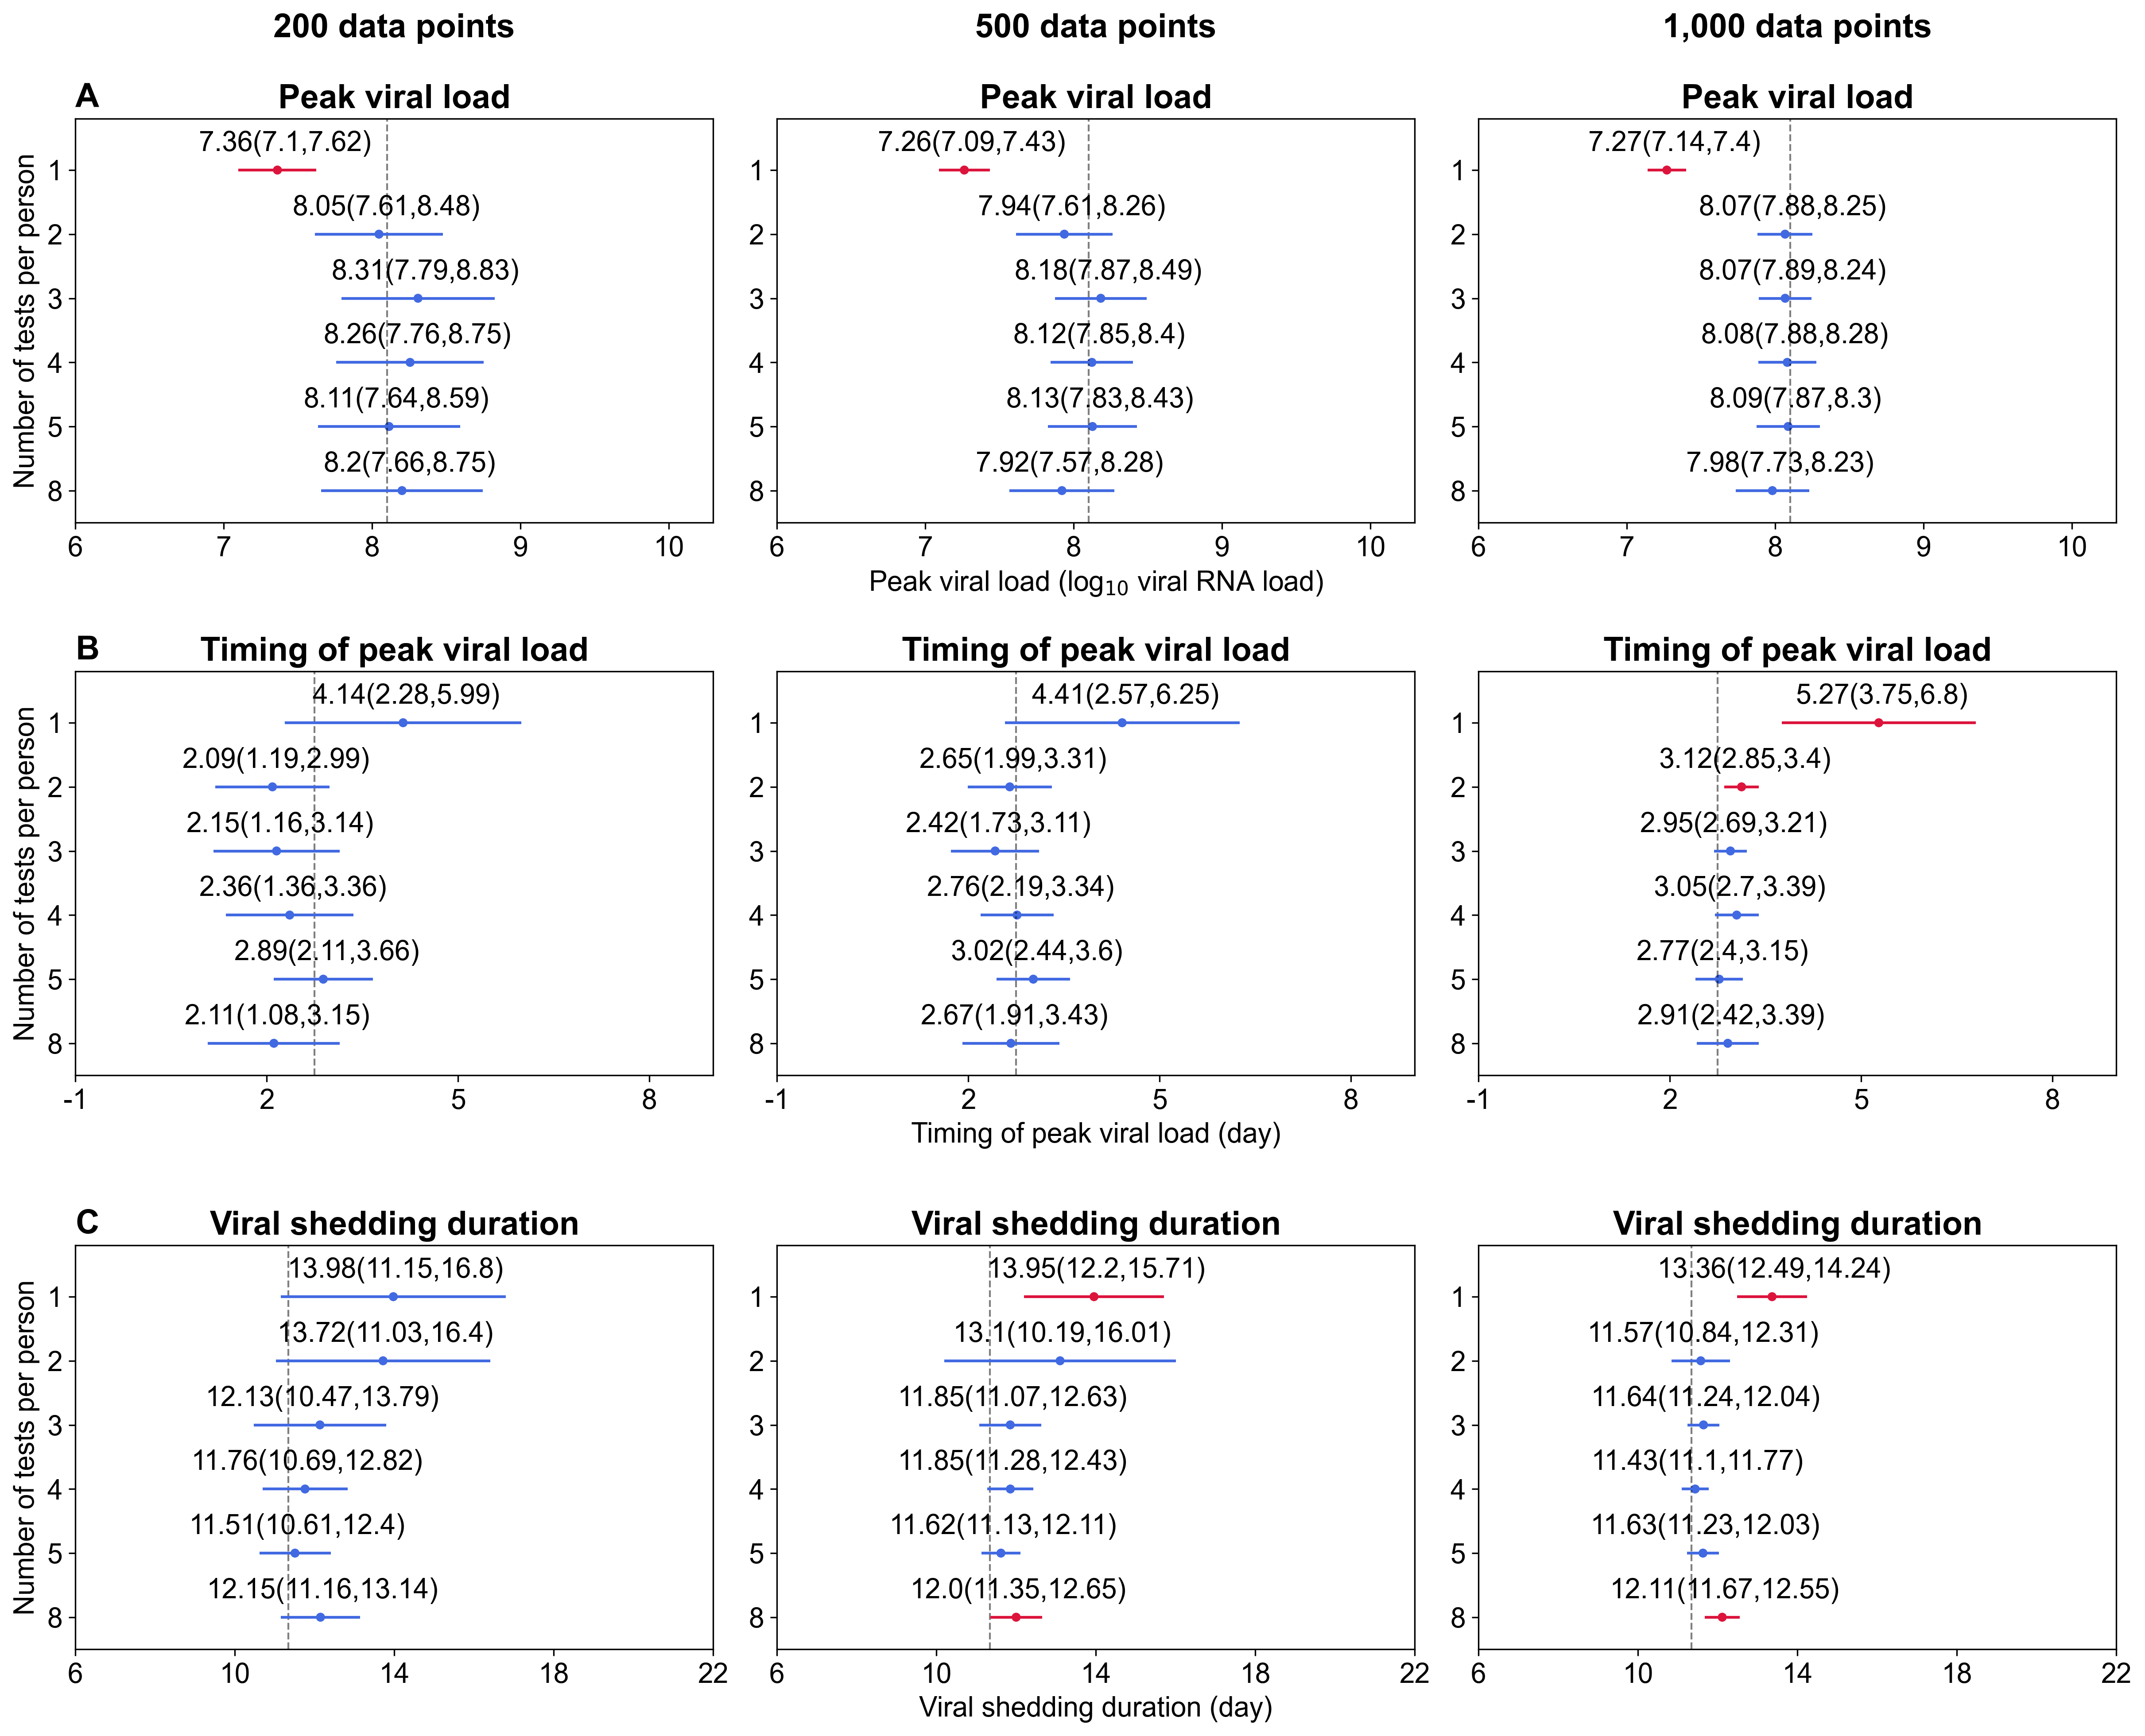

In [ ]:
fig=plt.figure(figsize=(16,16),dpi=set_dpi)

gs[0]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.81, left=0, right=0.3)
gs[1]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.81, left=0.33, right=0.63)
gs[2]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.81, left=0.66, right=0.96)
gs[3]=fig.add_gridspec(nrows=1,ncols=1,top=0.74, bottom=0.55, left=0, right=0.3)
gs[4]=fig.add_gridspec(nrows=1,ncols=1,top=0.74, bottom=0.55, left=0.33, right=0.63)
gs[5]=fig.add_gridspec(nrows=1,ncols=1,top=0.74, bottom=0.55, left=0.66, right=0.96)
gs[6]=fig.add_gridspec(nrows=1,ncols=1,top=0.47, bottom=0.28, left=0, right=0.3)
gs[7]=fig.add_gridspec(nrows=1,ncols=1,top=0.47, bottom=0.28, left=0.33, right=0.63)
gs[8]=fig.add_gridspec(nrows=1,ncols=1,top=0.47, bottom=0.28, left=0.66, right=0.96)


# 200
N_test = N_test_list[0]
result_df = pd.read_csv(os.path.join(inputfolder, f"MEAN_1STD_{N_test}_S{S_list[0]}.csv"))
true_df = true_df_1
result_df['duration_diff'] = (result_df['duration_lower'] <= true_df['duration'].values[0]) & (result_df['duration_upper'] >= true_df['duration'].values[0])
result_df['peaksize_diff'] = (result_df['peaksize_lower'] <= true_df['peaksize'].values[0]) & (result_df['peaksize_upper'] >= true_df['peaksize'].values[0])
result_df['peaktime_diff'] = (result_df['peaktime_lower'] <= true_df['peaktime'].values[0]) & (result_df['peaktime_upper'] >= true_df['peaktime'].values[0])
result_df['duration_color'] = np.where(result_df['duration_diff'] == True, "royalblue", "crimson")
result_df['peaksize_color'] = np.where(result_df['peaksize_diff'] == True, "royalblue", "crimson")
result_df['peaktime_color'] = np.where(result_df['peaktime_diff'] == True, "royalblue", "crimson")

i=0
metric=metrics[0]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="Unnamed: 0", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['peaksize'][0], color='black', alpha=0.5, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["Unnamed: 0"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.05, result_df["Unnamed: 0"][j]-0.3, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(str(200) + " data points\n\n" + titles[0], weight="bold", fontsize=18)
ax[i].set_xlim(6, 10.3)
ax[i].set_xticks(range(6, 11))
ax[i].set_xticklabels([6, 7, 8, 9, 10], fontsize=15)

i=3
metric=metrics[1]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="Unnamed: 0", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['peaktime'][0], color='black', alpha=0.5, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["Unnamed: 0"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.05, result_df["Unnamed: 0"][j]-0.3, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[1], weight="bold",fontsize=18)
ax[i].set_xlim(-0.1, 9)
ax[i].set_xticks(range(-1, 10, 3))
ax[i].set_xticklabels([-1, 2, 5, 8], fontsize=15)

i=6
metric=metrics[2]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="Unnamed: 0", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['duration'][0], color='black', alpha=0.5, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["Unnamed: 0"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.05, result_df["Unnamed: 0"][j]-0.3, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[2], weight="bold",fontsize=18)
ax[i].set_xlim(6, 22)
ax[i].set_xticks(range(6, 23, 4))
ax[i].set_xticklabels([6, 10, 14, 18, 22], fontsize=15)



# 500
N_test = N_test_list[1]

true_df = true_df_2
result_df = pd.read_csv(os.path.join(inputfolder, f"MEAN_1STD_{N_test}_S{S_list[0]}.csv"))
result_df = result_df[result_df["indi_test_num"].isin([1, 2, 3, 4, 5, 8])]
result_df['duration_diff'] = (result_df['duration_lower'] <= true_df['duration'].values[0]) & (result_df['duration_upper'] >= true_df['duration'].values[0])
result_df['peaksize_diff'] = (result_df['peaksize_lower'] <= true_df['peaksize'].values[0]) & (result_df['peaksize_upper'] >= true_df['peaksize'].values[0])
result_df['peaktime_diff'] = (result_df['peaktime_lower'] <= true_df['peaktime'].values[0]) & (result_df['peaktime_upper'] >= true_df['peaktime'].values[0])
result_df['duration_color'] = np.where(result_df['duration_diff'] == True, "royalblue", "crimson")
result_df['peaksize_color'] = np.where(result_df['peaksize_diff'] == True, "royalblue", "crimson")
result_df['peaktime_color'] = np.where(result_df['peaktime_diff'] == True, "royalblue", "crimson")

i=1
metric=metrics[0]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="Unnamed: 0", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['peaksize'][0], color='black', alpha=0.5, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["Unnamed: 0"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.05, result_df["Unnamed: 0"][j]-0.3, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(str(500) + " data points\n\n" + titles[0], weight="bold", fontsize=18)
ax[i].set_xlim(6, 10.3)
ax[i].set_xticks(range(6, 11))
ax[i].set_xticklabels([6, 7, 8, 9, 10], fontsize=15)
ax[i].set_xlabel("Peak viral load (log$_{10}$ viral RNA load)", fontsize=15)

i=4
metric=metrics[1]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="Unnamed: 0", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['peaktime'][0], color='black', alpha=0.5, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["Unnamed: 0"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.05, result_df["Unnamed: 0"][j]-0.3, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[1], weight="bold",fontsize=18)
ax[i].set_xlim(-0.1, 9)
ax[i].set_xticks(range(-1, 10, 3))
ax[i].set_xticklabels([-1, 2, 5, 8], fontsize=15)
ax[i].set_xlabel("Timing of peak viral load (day)", fontsize=15)

i=7
metric=metrics[2]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="Unnamed: 0", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['duration'][0], color='black', alpha=0.5, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["Unnamed: 0"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.05, result_df["Unnamed: 0"][j]-0.3, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[2], weight="bold",fontsize=18)
ax[i].set_xlim(6, 22)
ax[i].set_xticks(range(6, 23, 4))
ax[i].set_xticklabels([6, 10, 14, 18, 22], fontsize=15)
ax[i].set_xlabel(titles[2]+' (day)', fontsize=15)

# 1000
N_test = N_test_list[2]

true_df = true_df_3
result_df = pd.read_csv(os.path.join(inputfolder, f"MEAN_1STD_{N_test}_S{S_list[0]}.csv"))
result_df = result_df[result_df["indi_test_num"].isin([1, 2, 3, 4, 5, 8])]
result_df['duration_diff'] = (result_df['duration_lower'] <= true_df['duration'].values[0]) & (result_df['duration_upper'] >= true_df['duration'].values[0])
result_df['peaksize_diff'] = (result_df['peaksize_lower'] <= true_df['peaksize'].values[0]) & (result_df['peaksize_upper'] >= true_df['peaksize'].values[0])
result_df['peaktime_diff'] = (result_df['peaktime_lower'] <= true_df['peaktime'].values[0]) & (result_df['peaktime_upper'] >= true_df['peaktime'].values[0])
result_df['duration_color'] = np.where(result_df['duration_diff'] == True, "royalblue", "crimson")
result_df['peaksize_color'] = np.where(result_df['peaksize_diff'] == True, "royalblue", "crimson")
result_df['peaktime_color'] = np.where(result_df['peaktime_diff'] == True, "royalblue", "crimson")


i=2
metric=metrics[0]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="Unnamed: 0", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['peaksize'][0], color='black', alpha=0.5, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["Unnamed: 0"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.05, result_df["Unnamed: 0"][j]-0.3, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(str("1,000") + " data points\n\n" + titles[0], weight="bold", fontsize=18)
ax[i].set_xlim(6, 10.3)
ax[i].set_xticks(range(6, 11))
ax[i].set_xticklabels([6, 7, 8, 9, 10], fontsize=15)

i=5
metric=metrics[1]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="Unnamed: 0", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['peaktime'][0], color='black', alpha=0.5, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["Unnamed: 0"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.05, result_df["Unnamed: 0"][j]-0.3, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[1], weight="bold",fontsize=18)
ax[i].set_xlim(-0.1, 9)
ax[i].set_xticks(range(-1, 10, 3))
ax[i].set_xticklabels([-1, 2, 5, 8], fontsize=15)

i=8
metric=metrics[2]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="Unnamed: 0", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['duration'][0], color='black', alpha=0.5, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["Unnamed: 0"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.05, result_df["Unnamed: 0"][j]-0.3, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[2], weight="bold",fontsize=18)
ax[i].set_xlim(6, 22)
ax[i].set_xticks(range(6, 23, 4))
ax[i].set_xticklabels([6, 10, 14, 18, 22], fontsize=15)


for i in range(9):
    if i%3 == 0:
        ax[i].set_ylabel("Number of tests per person", fontsize=15)
        ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i//3]),transform=ax[i].transAxes,weight='bold',fontsize=18)
    ax[i].invert_yaxis()
    ax[i].margins(x=0)
    ax[i].set_ylim(6.5,0.2)
    ax[i].set_yticks(result_df["Unnamed: 0"])
    ax[i].set_yticklabels(["1", "2", "3", "4", "5", "8"], fontsize=15)
    ax[i].grid(False)

plt.show()


# fig.savefig(figurefolder+'/Fig4.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# fig.savefig(figurefolder+'/Fig4.png', format='png', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)

## Fig S2.

In [21]:
# Basic settings
alpha = 0.05  # Statistical significance level
N = 10000      # The number of ground truth VL (individuals)
min_time, max_time, time_interval = 0, 30, 0.01
times = np.arange(min_time, max_time + time_interval, time_interval)
detection_limit = (40 - 49.5932) / (-3.6097)  # Threshold: detection limit (log10 form)

# Scenario settings
S_list = [3]
M_list = [1, 2, 3, 4, 5, 8]
N_test_list = [200, 500, 1000]
variant = "delta"
K = 100

def parameter_confidence_intervals(population_parameters):
    population_parameters = population_parameters.copy()
    population_parameters['se_trans'] = np.where(
        population_parameters.index.str.endswith("_pop") |
        population_parameters.index.str.startswith("omega_"),
        np.sqrt(np.log((1 + np.sqrt(1 + (2 * population_parameters['se_sa'] / population_parameters['value'])**2)) / 2)),
        np.nan
    )
    population_parameters['lower'] = np.where(
        population_parameters.index.str.endswith("_pop") |
        population_parameters.index.str.startswith("omega_"),
        np.exp(np.log(population_parameters['value']) + np.quantile(np.random.normal(0, 1, 10000), alpha / 2) * population_parameters['se_trans']),
        population_parameters['value'] + np.quantile(np.random.normal(0, 1, 10000), alpha / 2) * population_parameters['se_sa']
    )
    population_parameters['upper'] = np.where(
        population_parameters.index.str.endswith("_pop") |
        population_parameters.index.str.startswith("omega_"),
        np.exp(np.log(population_parameters['value']) + np.quantile(np.random.normal(0, 1, 10000), 1 - (alpha / 2)) * population_parameters['se_trans']),
        population_parameters['value'] + np.quantile(np.random.normal(0, 1, 10000), 1 - (alpha / 2)) * population_parameters['se_sa']
    )
    return population_parameters

def get_predicted_parameters(population_parameters):
    params = {param: population_parameters.loc[param, 'value'] if param in population_parameters.index else 0
              for param in ["gamma_pop", "beta1_pop", "delta_pop", "tau_pop"]}
    params['beta1_pop'] = params['beta1_pop'] * 1e-5
    return params

def covfun2(t, y, pars):
    f, V = y
    beta, gamma, delta = pars['beta1_pop'], pars['gamma_pop'], pars['delta_pop']
    dfdt = -beta * f * V
    dVdt = gamma * f * V - delta * V
    return [dfdt, dVdt]


def esti_vl(params):
    solution = solve_ivp(
        covfun2, [0, max_time], [1, 0.01], t_eval=times, args=(params,),
        rtol=0.00004, atol=1e-12
    )
    return pd.DataFrame({"time": solution.t, "aV": np.log10(solution.y[1])})


In [ ]:
S_list = [3]
M_list = [4, 5, 8]
N_test_list = [200, 500, 1000]

sim_data_temp = [] ; VL = []

VL_list = [[[[] for _ in S_list] for _ in M_list] for _ in N_test_list]
sim_data_list = [[[[] for _ in S_list] for _ in M_list] for _ in N_test_list]

for n_idx, N_test in enumerate(N_test_list):
    for m_idx, M in enumerate(M_list):
        for s_idx, S in enumerate(S_list):
            VL = []
            N_partici = N_test // M
            
            for i in range(1, K + 1):
                sim_pop = pd.read_csv(f"{project_path}{N_test}obsdata_N_{N_partici}_M_{M}_S_{S}_{i}/populationParameters.txt", sep=",", index_col=0)
                sim_data = pd.read_csv(f"{datafolder}{N_test}obsdata_N_{N_partici}_M_{M}_S_{S}_{i}.csv")
                sim_data_temp.append(sim_data)
                sim_pop_params = parameter_confidence_intervals(sim_pop)
                pred_sim_pop_params = get_predicted_parameters(sim_pop_params)
                
                fit = esti_vl(pred_sim_pop_params)
                VL.append(fit)
            
            VL_list[n_idx][m_idx][s_idx] = VL
            sim_data_list[n_idx][m_idx][s_idx] = sim_data_temp

In [23]:
color_list = ["#00A087", "#FFC000"]

gs=[0]*9
ax=[0]*9

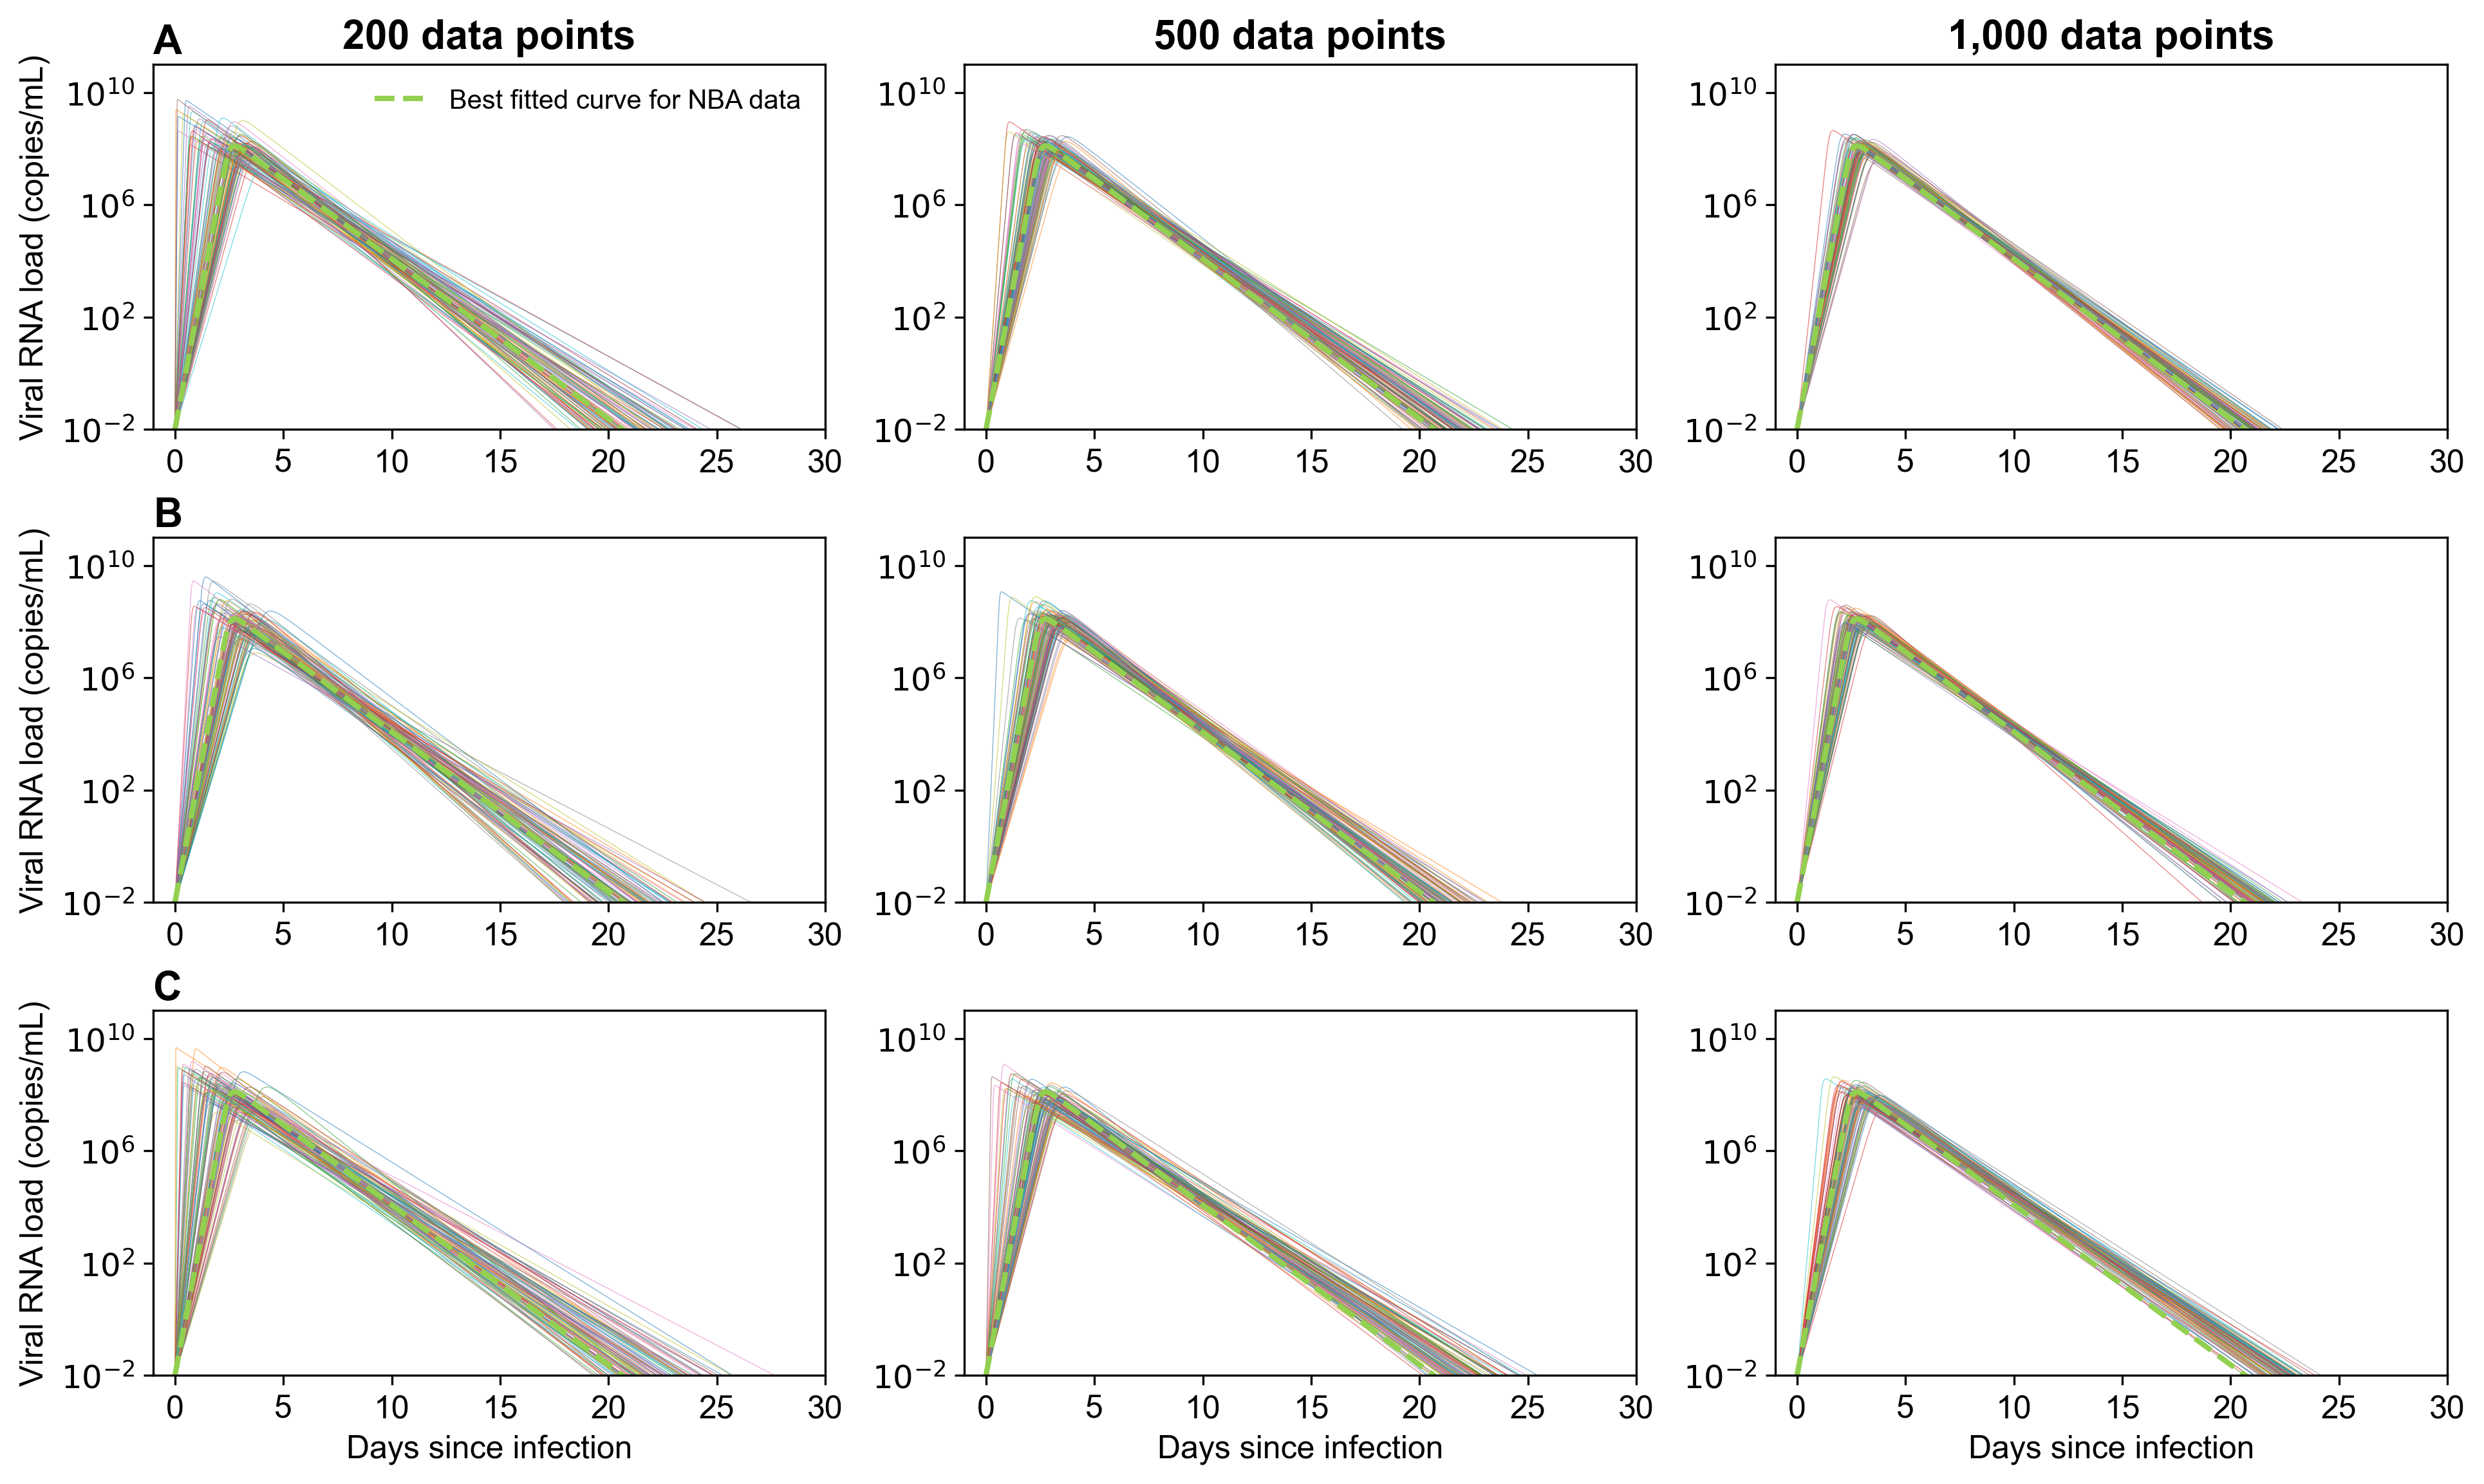

In [24]:
fig=plt.figure(figsize=(12,7),dpi=set_dpi)

gs[0]=fig.add_gridspec(nrows=1,ncols=1,top=0.97, bottom=0.70, left=0, right=0.29)
gs[1]=fig.add_gridspec(nrows=1,ncols=1,top=0.97, bottom=0.70, left=0.35, right=0.64)
gs[2]=fig.add_gridspec(nrows=1,ncols=1,top=0.97, bottom=0.70, left=0.7, right=0.99)
gs[3]=fig.add_gridspec(nrows=1,ncols=1,top=0.62, bottom=0.35, left=0, right=0.29)
gs[4]=fig.add_gridspec(nrows=1,ncols=1,top=0.62, bottom=0.35, left=0.35, right=0.64)
gs[5]=fig.add_gridspec(nrows=1,ncols=1,top=0.62, bottom=0.35, left=0.7, right=0.99)
gs[6]=fig.add_gridspec(nrows=1,ncols=1,top=0.27, bottom=0, left=0, right=0.29)
gs[7]=fig.add_gridspec(nrows=1,ncols=1,top=0.27, bottom=0, left=0.35, right=0.64)
gs[8]=fig.add_gridspec(nrows=1,ncols=1,top=0.27, bottom=0, left=0.7, right=0.99)

s_idx=0
for i in range(9):
    ax[i]=fig.add_subplot(gs[i][0])
    
    if i < 3:
        m_idx = 0
    elif i < 6:
        m_idx = 1
    elif i < 9:
        m_idx = 2
    
    VL=VL_list[i%3][m_idx][s_idx]
    sim_data=sim_data_list[i%3][m_idx][s_idx]
    
    for j in range(K):
        ax[i].plot(VL[j]['time'], VL[j]['aV'], linewidth=0.3, color=plt.cm.tab10(j % 10), alpha=0.6)
    ax[i].plot(delta_popfit['time'], delta_popfit['VL'], color="#92D050", label='Best fitted curve for NBA data', lw=2, linestyle='--')
    ax[i].set_xlim(-1, 30)
    ax[i].set_ylim(-2, 11)    
    ax[i].set_xticks(np.arange(0, 31, 5))
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].set_yticks(np.arange(-2, 14, 4))
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f"$10^{{{int(val)}}}$"))
    ax[i].margins(x=0)


ax[0].set_title("200 data points", weight="bold", fontsize=15)
ax[1].set_title("500 data points", weight="bold", fontsize=15)
ax[2].set_title("1,000 data points", weight="bold", fontsize=15)

ax[0].set_ylabel("Viral RNA load (copies/mL)", fontsize=12)
ax[3].set_ylabel("Viral RNA load (copies/mL)", fontsize=12)
ax[6].set_ylabel("Viral RNA load (copies/mL)", fontsize=12)

ax[6].set_xlabel("Days since infection", fontsize=12)
ax[7].set_xlabel("Days since infection", fontsize=12)
ax[8].set_xlabel("Days since infection", fontsize=12)

ax[0].legend(loc='upper right', fontsize=10, frameon=False)


for j in range(9):
    if j%3 == 0:
        ax[j].text(0,1.03,'{}'.format(string.ascii_uppercase[j//3]),transform=ax[j].transAxes, weight='bold',fontsize=15)

plt.show()

# fig.savefig(figurefolder+'FigS2.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# fig.savefig(figurefolder+'FigS2.png', format='png', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)


## Fig S3.

In [25]:
# Test cases
S_list = [3]
M_list = [1, 2, 3, 4, 5, 8]
N_test_list = [200, 500, 1000]

true_tau = 2.19
ref_tau = 4.09

# Read true values
true_df = pd.read_csv(os.path.join(inputfolder, "True_parameter_delta.csv"))
true_df['tau'] = true_tau
print("true beta:", true_df['beta'][0], "true delta:", true_df['delta'][0], "true gamma:", true_df['gamma'][0], "true_tau:", true_tau)

true beta: 0.0052521487149342 true delta: 1.31414648002284 true gamma: 10.7260041153183 true_tau: 2.19


In [ ]:
metrics = ['beta', 'delta', 'gamma', "tau"]
titles = ["β", "δ", "γ", "τ"]
upper_limit = 20 

In [ ]:
beta_se = 0.0013
delta_se = 0.051
gamma_se = 0.52
tau_se = 0.087
tau_se_ref = 1.08
alpha = 0.05

true_df['beta_lower'] = true_df['beta'] - 1.96 * beta_se
true_df['beta_upper'] = true_df['beta'] + 1.96 * beta_se
true_df['delta_lower'] = true_df['delta'] - 1.96 * delta_se
true_df['delta_upper'] = true_df['delta'] + 1.96 * delta_se
true_df['gamma_lower'] = true_df['gamma'] - 1.96 * gamma_se
true_df['gamma_upper'] = true_df['gamma'] + 1.96 * gamma_se
true_df['tau_lower'] = true_df['tau'] - 1.96 * tau_se
true_df['tau_upper'] = true_df['tau'] + 1.96 * tau_se


In [28]:
gs=[0]*12
ax=[0]*12

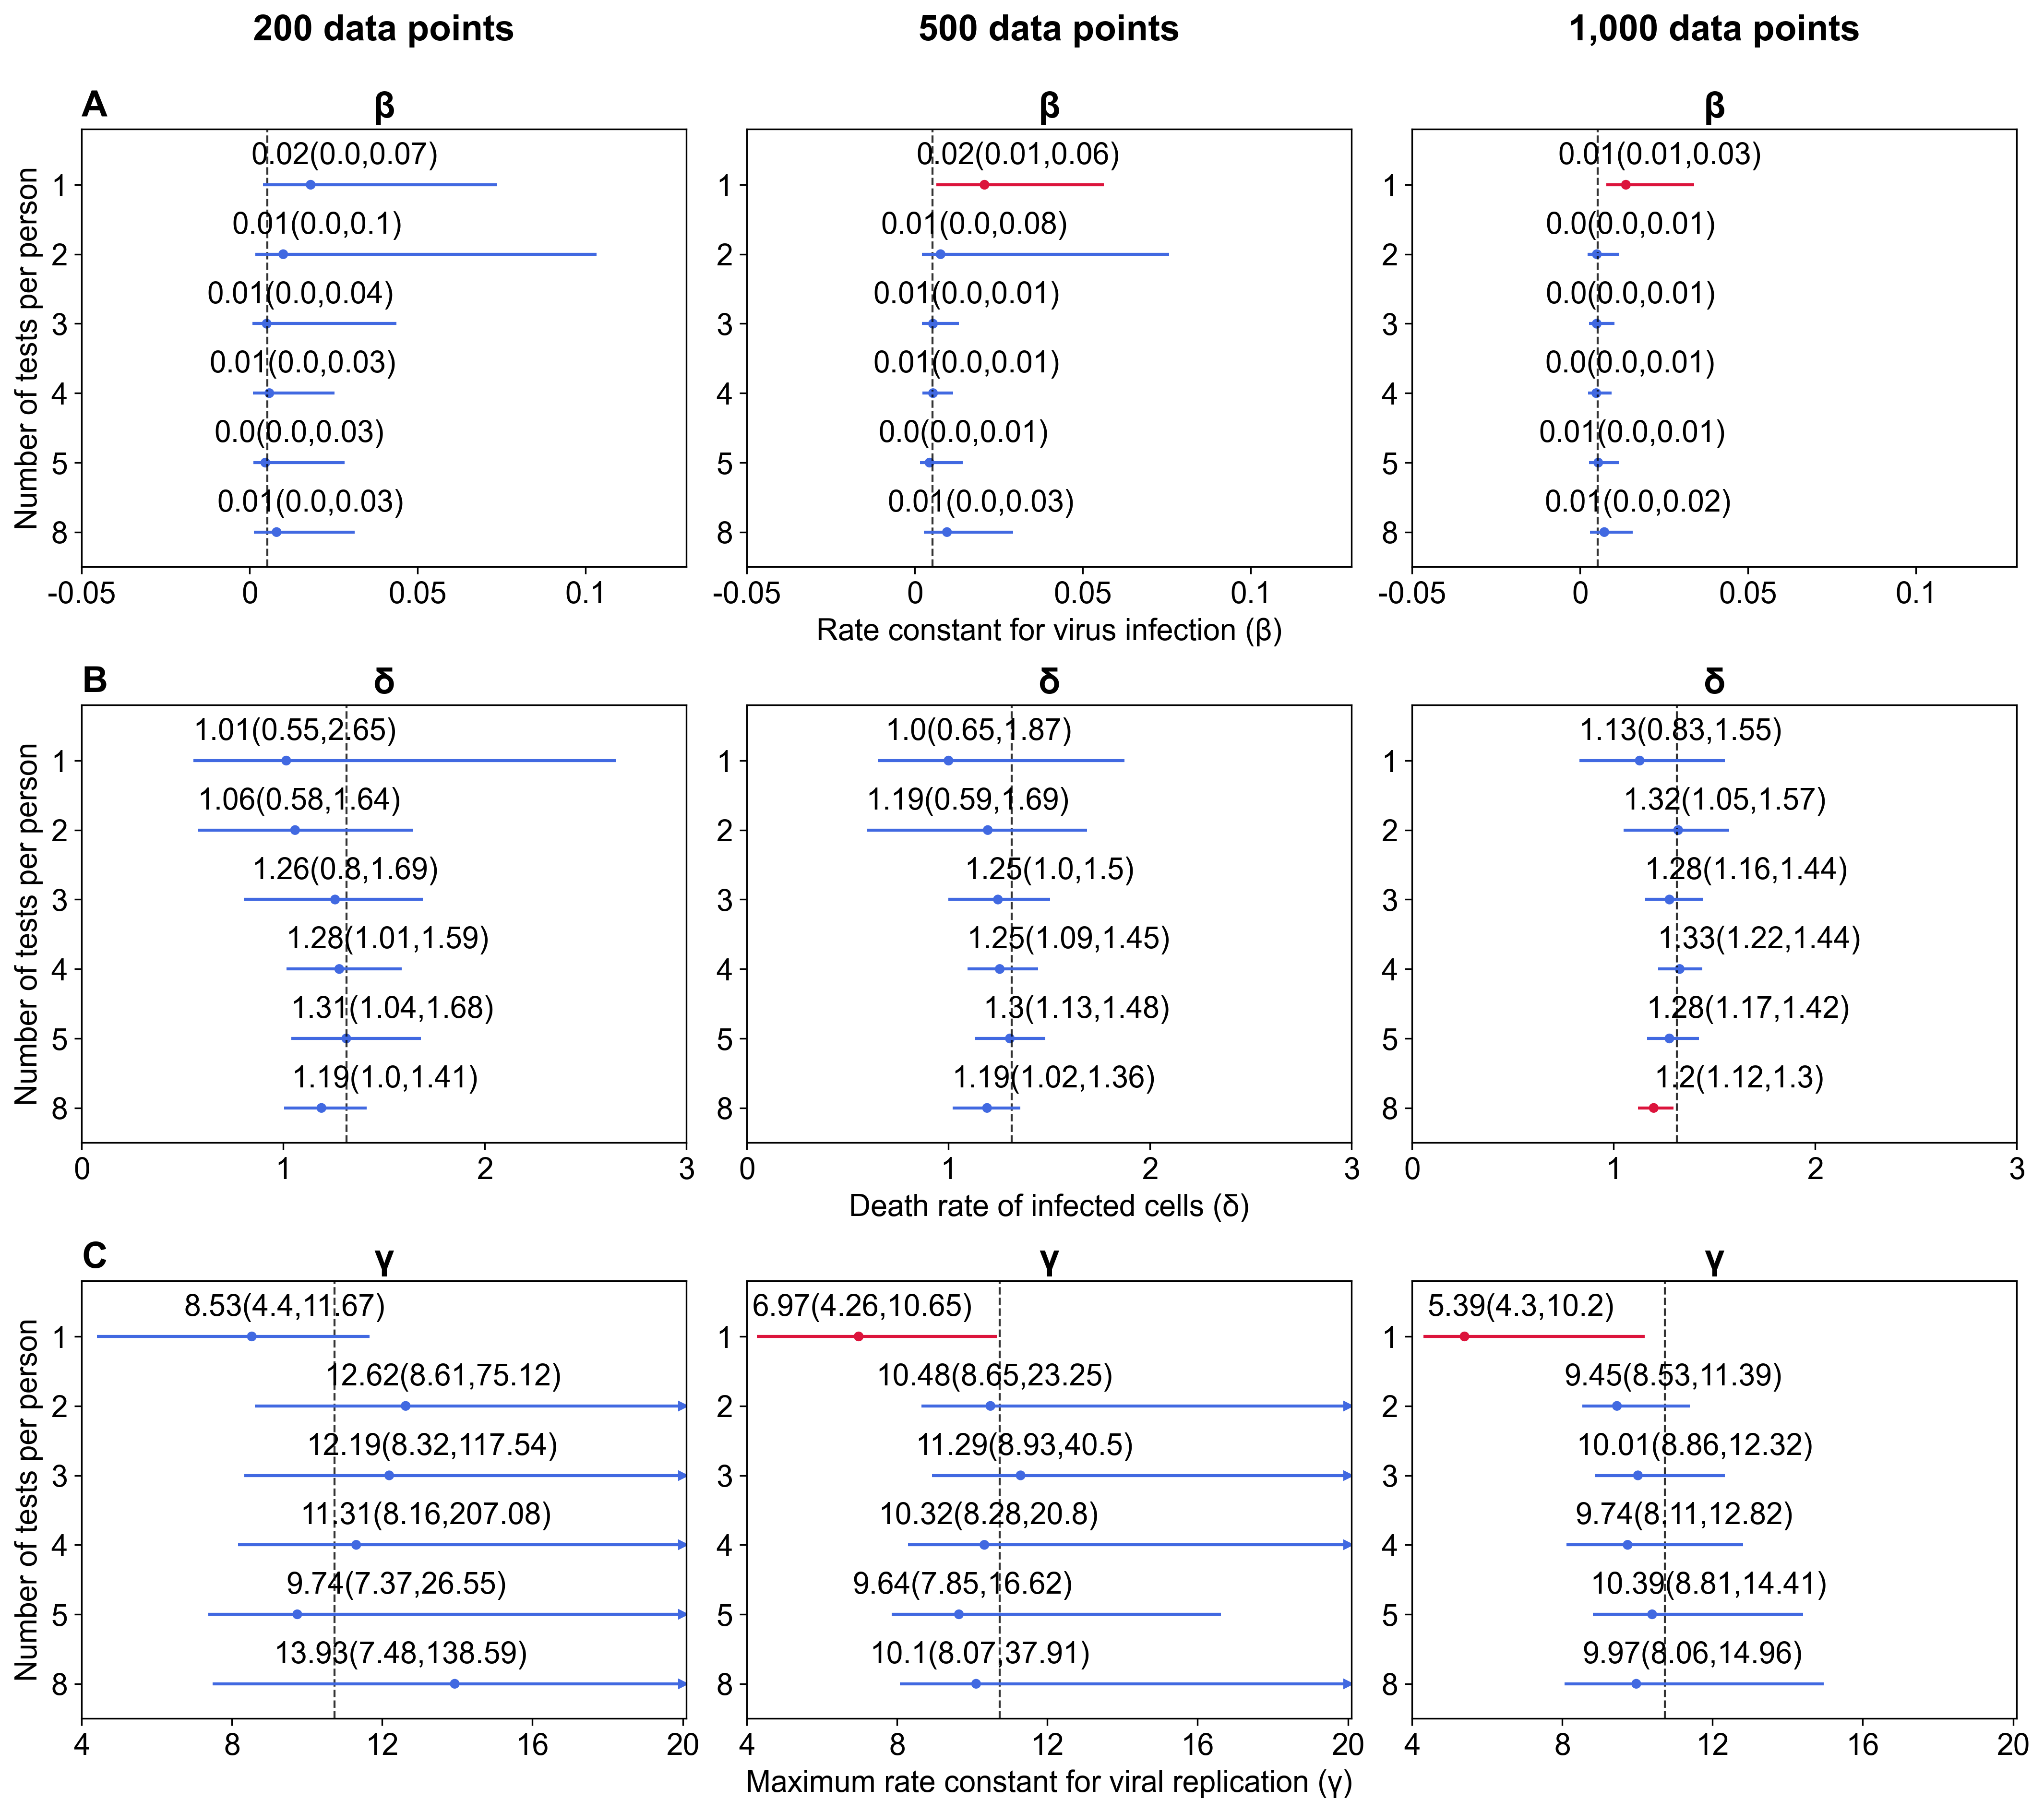

In [ ]:
fig=plt.figure(figsize=(14,16),dpi=set_dpi)

gs[0]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.81, left=0, right=0.3)
gs[1]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.81, left=0.33, right=0.63)
gs[2]=fig.add_gridspec(nrows=1,ncols=1,top=1, bottom=0.81, left=0.66, right=0.96)
gs[3]=fig.add_gridspec(nrows=1,ncols=1,top=0.75, bottom=0.56, left=0, right=0.3)
gs[4]=fig.add_gridspec(nrows=1,ncols=1,top=0.75, bottom=0.56, left=0.33, right=0.63)
gs[5]=fig.add_gridspec(nrows=1,ncols=1,top=0.75, bottom=0.56, left=0.66, right=0.96)
gs[6]=fig.add_gridspec(nrows=1,ncols=1,top=0.50, bottom=0.31, left=0, right=0.3)
gs[7]=fig.add_gridspec(nrows=1,ncols=1,top=0.50, bottom=0.31, left=0.33, right=0.63)
gs[8]=fig.add_gridspec(nrows=1,ncols=1,top=0.50, bottom=0.31, left=0.66, right=0.96)
gs[9]=fig.add_gridspec(nrows=1,ncols=1,top=0.25, bottom=0.06, left=0, right=0.3)
gs[10]=fig.add_gridspec(nrows=1,ncols=1,top=0.25, bottom=0.06, left=0.33, right=0.63)
gs[11]=fig.add_gridspec(nrows=1,ncols=1,top=0.25, bottom=0.06, left=0.66, right=0.96)

# 200
N_test = N_test_list[0]
result_df = pd.read_csv(os.path.join(inputfolder, f"Parameter_QT_{N_test}_S{S_list[0]}.csv"))
result_df = result_df[result_df["indi_test_num"].isin([1, 2, 3, 4, 5, 8])].reset_index(drop=True)
result_df['index'] = range(1, len(result_df) + 1)
result_df['beta_diff'] = (true_df['beta'].values[0] >= result_df['beta_lower']) & (true_df['beta'].values[0] <= result_df['beta_upper'])
result_df['delta_diff'] = (true_df['delta'].values[0] >= result_df['delta_lower']) & (true_df['delta'].values[0] <= result_df['delta_upper'])
result_df['gamma_diff'] = (true_df['gamma'].values[0] >= result_df['gamma_lower']) & (true_df['gamma'].values[0] <= result_df['gamma_upper'])
result_df['beta_color'] = np.where(result_df['beta_diff'] == True, "royalblue", "crimson")
result_df['delta_color'] = np.where(result_df['delta_diff'] == True, "royalblue", "crimson")
result_df['gamma_color'] = np.where(result_df['gamma_diff'] == True, "royalblue", "crimson")
result_df['gamma_adjust'] = 0 ; result_df['gamma_adjust_lower'] = 0 ; result_df['gamma_adjust_upper'] = 0
result_df['gamma_adjust'] = np.where(result_df['gamma'] > upper_limit, upper_limit, result_df['gamma'])
result_df['gamma_adjust_lower'] = np.where(result_df['gamma_lower'] > upper_limit, upper_limit, result_df['gamma_lower'])
result_df['gamma_adjust_upper'] = np.where(result_df['gamma_upper'] > upper_limit, upper_limit, result_df['gamma_upper'])

i=0
metric=metrics[0]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['beta'][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.01, result_df["index"][j]-0.3, 
                str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(str(200) + " data points\n\n" + titles[0], weight="bold", fontsize=18)
ax[i].set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15])
ax[i].set_xticklabels([-0.1, -0.05, 0, 0.05, 0.1, 0.15], fontsize=15)
ax[i].set_xlim(-0.05, 0.13)
ax[i].set_ylabel("Number of tests per person", fontsize=15)


i=3
metric=metrics[1]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['delta'][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[f"{metric}_lower"][j]+0.5, result_df["index"][j]-0.3, 
                str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[1], weight="bold",fontsize=18)
ax[i].set_xticks(range(0, 4))
ax[i].set_xticklabels(range(0, 4), fontsize=15)
ax[i].set_xlim(0, 3)
ax[i].set_ylabel("Number of tests per person", fontsize=15)


i=6
metric2=metrics[2]
metric='gamma_adjust'
ax[i]=fig.add_subplot(gs[i][0])
filtered_df = result_df[result_df[metric] < upper_limit]
ax[i].scatter(x=metric, y="index", data=filtered_df, color=filtered_df[metric2+'_color'], s=15)
# ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric2+'_color'], s=15)
ax[i].axvline(x=true_df[metric2][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric2+'_color'][j], capsize=0)
    if result_df[f"{metric2}_upper"][j] > upper_limit:
        ax[i].plot(result_df[f"{metric}_upper"][j], result_df["index"][j],  
                marker='>', markersize=4, color=result_df[metric2+'_color'][j])
    ax[i].text(result_df[f"{metric2}_lower"][j]+5, result_df["index"][j]-0.3, 
                str(round(result_df[metric2][j],2))+"("+str(round(result_df[f"{metric2}_lower"][j],2))+","+str(round(result_df[f"{metric2}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[2], weight="bold",fontsize=18)
ax[i].set_xticks(range(4, 21, 4))
ax[i].set_xticklabels(range(4, 21, 4), fontsize=15)
ax[i].set_xlim(4, 20.1)
ax[i].set_ylabel("Number of tests per person", fontsize=15)


# 500
N_test=N_test_list[1]
result_df = pd.read_csv(os.path.join(inputfolder, f"Parameter_QT_{N_test}_S{S_list[0]}.csv"))
result_df = result_df[result_df["indi_test_num"].isin([1, 2, 3, 4, 5, 8])].reset_index(drop=True)
result_df['index'] = range(1, len(result_df) + 1)
result_df['beta_diff'] = (true_df['beta'].values[0] >= result_df['beta_lower']) & (true_df['beta'].values[0] <= result_df['beta_upper'])
result_df['delta_diff'] = (true_df['delta'].values[0] >= result_df['delta_lower']) & (true_df['delta'].values[0] <= result_df['delta_upper'])
result_df['gamma_diff'] = (true_df['gamma'].values[0] >= result_df['gamma_lower']) & (true_df['gamma'].values[0] <= result_df['gamma_upper'])
result_df['beta_color'] = np.where(result_df['beta_diff'] == True, "royalblue", "crimson")
result_df['delta_color'] = np.where(result_df['delta_diff'] == True, "royalblue", "crimson")
result_df['gamma_color'] = np.where(result_df['gamma_diff'] == True, "royalblue", "crimson")
result_df['gamma_adjust'] = 0 ; result_df['gamma_adjust_lower'] = 0 ; result_df['gamma_adjust_upper'] = 0
result_df['gamma_adjust'] = np.where(result_df['gamma'] > upper_limit, upper_limit, result_df['gamma'])
result_df['gamma_adjust_lower'] = np.where(result_df['gamma_lower'] > upper_limit, upper_limit, result_df['gamma_lower'])
result_df['gamma_adjust_upper'] = np.where(result_df['gamma_upper'] > upper_limit, upper_limit, result_df['gamma_upper'])

i=1
metric=metrics[0]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['beta'][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.01, result_df["index"][j]-0.3, 
                str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(str(500) + " data points\n\n" + titles[0], weight="bold", fontsize=18)
ax[i].set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15])
ax[i].set_xticklabels([-0.1, -0.05, 0, 0.05, 0.1, 0.15], fontsize=15)
ax[i].set_xlim(-0.05, 0.13)
ax[i].set_xlabel("Rate constant for virus infection (" + titles[0] + ")", fontsize=15)

i=4
metric=metrics[1]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['delta'][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[f"{metric}_lower"][j]+0.5, result_df["index"][j]-0.3, 
                str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[1], weight="bold",fontsize=18)
ax[i].set_xticks(range(0, 4))
ax[i].set_xticklabels(range(0, 4), fontsize=15)
ax[i].set_xlim(0, 3)
ax[i].set_xlabel("Death rate of infected cells ("+titles[1]+")", fontsize=15)

i=7
metric2=metrics[2]
metric='gamma_adjust'
ax[i]=fig.add_subplot(gs[i][0])
filtered_df = result_df[result_df[metric] < upper_limit]
ax[i].scatter(x=metric, y="index", data=filtered_df, color=filtered_df[metric2+'_color'], s=15)
# ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric2+'_color'], s=15)
ax[i].axvline(x=true_df[metric2][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric2+'_color'][j], capsize=0)
    if result_df[f"{metric2}_upper"][j] > upper_limit:
        ax[i].plot(result_df[f"{metric}_upper"][j], result_df["index"][j],  
                marker='>', markersize=4, color=result_df[metric2+'_color'][j])
    ax[i].text(result_df[metric2][j]+0.1, result_df["index"][j]-0.3, 
                str(round(result_df[metric2][j],2))+"("+str(round(result_df[f"{metric2}_lower"][j],2))+","+str(round(result_df[f"{metric2}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[2], weight="bold",fontsize=18)
ax[i].set_xticks(range(4, 21, 4))
ax[i].set_xticklabels(range(4, 21, 4), fontsize=15)
ax[i].set_xlim(4, 20.1)
ax[i].set_xlabel("Maximum rate constant for viral replication ("+titles[2]+")", fontsize=15)


# 1000
N_test=N_test_list[2]
result_df = pd.read_csv(os.path.join(inputfolder, f"Parameter_QT_{N_test}_S{S_list[0]}.csv"))
result_df = result_df[result_df["indi_test_num"].isin([1, 2, 3, 4, 5, 8])].reset_index(drop=True)
result_df['index'] = range(1, len(result_df) + 1)
result_df['beta_diff'] = (true_df['beta'].values[0] >= result_df['beta_lower']) & (true_df['beta'].values[0] <= result_df['beta_upper'])
result_df['delta_diff'] = (true_df['delta'].values[0] >= result_df['delta_lower']) & (true_df['delta'].values[0] <= result_df['delta_upper'])
result_df['gamma_diff'] = (true_df['gamma'].values[0] >= result_df['gamma_lower']) & (true_df['gamma'].values[0] <= result_df['gamma_upper'])
result_df['beta_color'] = np.where(result_df['beta_diff'] == True, "royalblue", "crimson")
result_df['delta_color'] = np.where(result_df['delta_diff'] == True, "royalblue", "crimson")
result_df['gamma_color'] = np.where(result_df['gamma_diff'] == True, "royalblue", "crimson")
result_df['gamma_adjust'] = 0 ; result_df['gamma_adjust_lower'] = 0 ; result_df['gamma_adjust_upper'] = 0
result_df['gamma_adjust'] = np.where(result_df['gamma'] > upper_limit, upper_limit, result_df['gamma'])
result_df['gamma_adjust_lower'] = np.where(result_df['gamma_lower'] > upper_limit, upper_limit, result_df['gamma_lower'])
result_df['gamma_adjust_upper'] = np.where(result_df['gamma_upper'] > upper_limit, upper_limit, result_df['gamma_upper'])


i=2
metric=metrics[0]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['beta'][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.01, result_df["index"][j]-0.3, 
                str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(str("1,000") + " data points\n\n" + titles[0], weight="bold", fontsize=18)
ax[i].set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15])
ax[i].set_xticklabels([-0.1, -0.05, 0, 0.05, 0.1, 0.15], fontsize=15)
ax[i].set_xlim(-0.05, 0.13)

i=5
metric=metrics[1]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df['delta'][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[f"{metric}_lower"][j]+0.5, result_df["index"][j]-0.3, 
                str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[1], weight="bold",fontsize=18)
ax[i].set_xticks(range(0, 4))
ax[i].set_xticklabels(range(0, 4), fontsize=15)
ax[i].set_xlim(0, 3)

i=8
metric2=metrics[2]
metric='gamma_adjust'
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric2+'_color'], s=15)
ax[i].axvline(x=true_df[metric2][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric2+'_color'][j], capsize=0)
    ax[i].text(result_df[metric2][j]+1.5, result_df["index"][j]-0.3, 
                str(round(result_df[metric2][j],2))+"("+str(round(result_df[f"{metric2}_lower"][j],2))+","+str(round(result_df[f"{metric2}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[2], weight="bold",fontsize=18)
ax[i].set_xticks(range(4, 21, 4))
ax[i].set_xticklabels(range(4, 21, 4), fontsize=15)
ax[i].set_xlim(4, 20.1)


for i in range(9):
    if i%3 == 0:
        ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i//3]),transform=ax[i].transAxes,weight='bold',fontsize=18)
    ax[i].invert_yaxis()
    ax[i].margins(x=0)
    ax[i].set_ylim(6.5,0.2)
    ax[i].set_yticks(result_df["index"])
    ax[i].set_yticklabels(["1", "2", "3", "4", "5", "8"], fontsize=15)
    ax[i].grid(False)

plt.show()


# fig.savefig(figurefolder+'FigS3.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# fig.savefig(figurefolder+'FigS3.png', format='png', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)

# Fig S5.

In [30]:
# Test cases
S_list = [3]
M_list = [1]
N_test = [1000]

# Read true values
true_df_1 = pd.read_csv(os.path.join(inputfolder, "True_MEAN_200_S"+str(S_list[0])+".csv"))
true_df_2 = pd.read_csv(os.path.join(inputfolder, "True_MEAN_500_S"+str(S_list[0])+".csv"))
true_df_3 = pd.read_csv(os.path.join(inputfolder, "True_MEAN_1000_S"+str(S_list[0])+".csv"))

metrics = ['peaksize', 'peaktime', 'duration']
titles = ['Peak viral load', 'Timing of peak viral load', 'Viral shedding duration']

y_labels = ['Yes', 'No']
y_title = 'Cosideration of random effects'

In [ ]:
true_df = true_df_3
result_df = pd.read_csv(os.path.join(inputfolder, f"MEAN_1STD_{N_test[0]}_S{S_list[0]}.csv")) # not consider random effect
result_df = result_df[result_df["indi_test_num"].isin([1])]
result_df['duration_diff'] = (result_df['duration_lower'] <= true_df['duration'].values[0]) & (result_df['duration_upper'] >= true_df['duration'].values[0])
result_df['peaksize_diff'] = (result_df['peaksize_lower'] <= true_df['peaksize'].values[0]) & (result_df['peaksize_upper'] >= true_df['peaksize'].values[0])
result_df['peaktime_diff'] = (result_df['peaktime_lower'] <= true_df['peaktime'].values[0]) & (result_df['peaktime_upper'] >= true_df['peaktime'].values[0])
result_df['duration_color'] = np.where(result_df['duration_diff'] == True, "royalblue", "crimson")
result_df['peaksize_color'] = np.where(result_df['peaksize_diff'] == True, "royalblue", "crimson")
result_df['peaktime_color'] = np.where(result_df['peaktime_diff'] == True, "royalblue", "crimson")
result_df['consider'] = 'No'

In [32]:
result_df = pd.concat([result_df, result_df.iloc[0:1].copy()], ignore_index=True)
result_df.iloc[1, result_df.columns.get_loc('consider')] = 'Yes'

In [33]:
#peaksize
cros_indi_peaksize = pd.read_csv(os.path.join(inputfolder, "crosssectional_indi_peaksize.csv"))
result_df.iloc[1, result_df.columns.get_loc('peaksize')] = cros_indi_peaksize.iloc[0,0]
result_df.iloc[1, result_df.columns.get_loc('peaksize_lower')] = cros_indi_peaksize.iloc[1,0]
result_df.iloc[1, result_df.columns.get_loc('peaksize_upper')] = cros_indi_peaksize.iloc[2,0]

#peaktime
cros_indi_peaktime = pd.read_csv(os.path.join(inputfolder, "crosssectional_indi_peaktime.csv"))
result_df.iloc[1, result_df.columns.get_loc('peaktime')] = cros_indi_peaktime.iloc[0,0]
result_df.iloc[1, result_df.columns.get_loc('peaktime_lower')] = cros_indi_peaktime.iloc[1,0]
result_df.iloc[1, result_df.columns.get_loc('peaktime_upper')] = cros_indi_peaktime.iloc[2,0]

#duration
cros_indi_duration = pd.read_csv(os.path.join(inputfolder, "crosssectional_indi_duration.csv"))
result_df.iloc[1, result_df.columns.get_loc('duration')] = cros_indi_duration.iloc[0,0]
result_df.iloc[1, result_df.columns.get_loc('duration_lower')] = cros_indi_duration.iloc[1,0]
result_df.iloc[1, result_df.columns.get_loc('duration_upper')] = cros_indi_duration.iloc[2,0]

result_df['index'] = range(1, len(result_df) + 1)
result_df['duration_diff'] = (result_df['duration_lower'] <= true_df['duration'].values[0]) & (result_df['duration_upper'] >= true_df['duration'].values[0])
result_df['peaksize_diff'] = (result_df['peaksize_lower'] <= true_df['peaksize'].values[0]) & (result_df['peaksize_upper'] >= true_df['peaksize'].values[0])
result_df['peaktime_diff'] = (result_df['peaktime_lower'] <= true_df['peaktime'].values[0]) & (result_df['peaktime_upper'] >= true_df['peaktime'].values[0])
result_df['duration_color'] = np.where(result_df['duration_diff'] == True, "royalblue", "crimson")
result_df['peaksize_color'] = np.where(result_df['peaksize_diff'] == True, "royalblue", "crimson")
result_df['peaktime_color'] = np.where(result_df['peaktime_diff'] == True, "royalblue", "crimson")


In [34]:
gs=[0]*3
ax=[0]*3

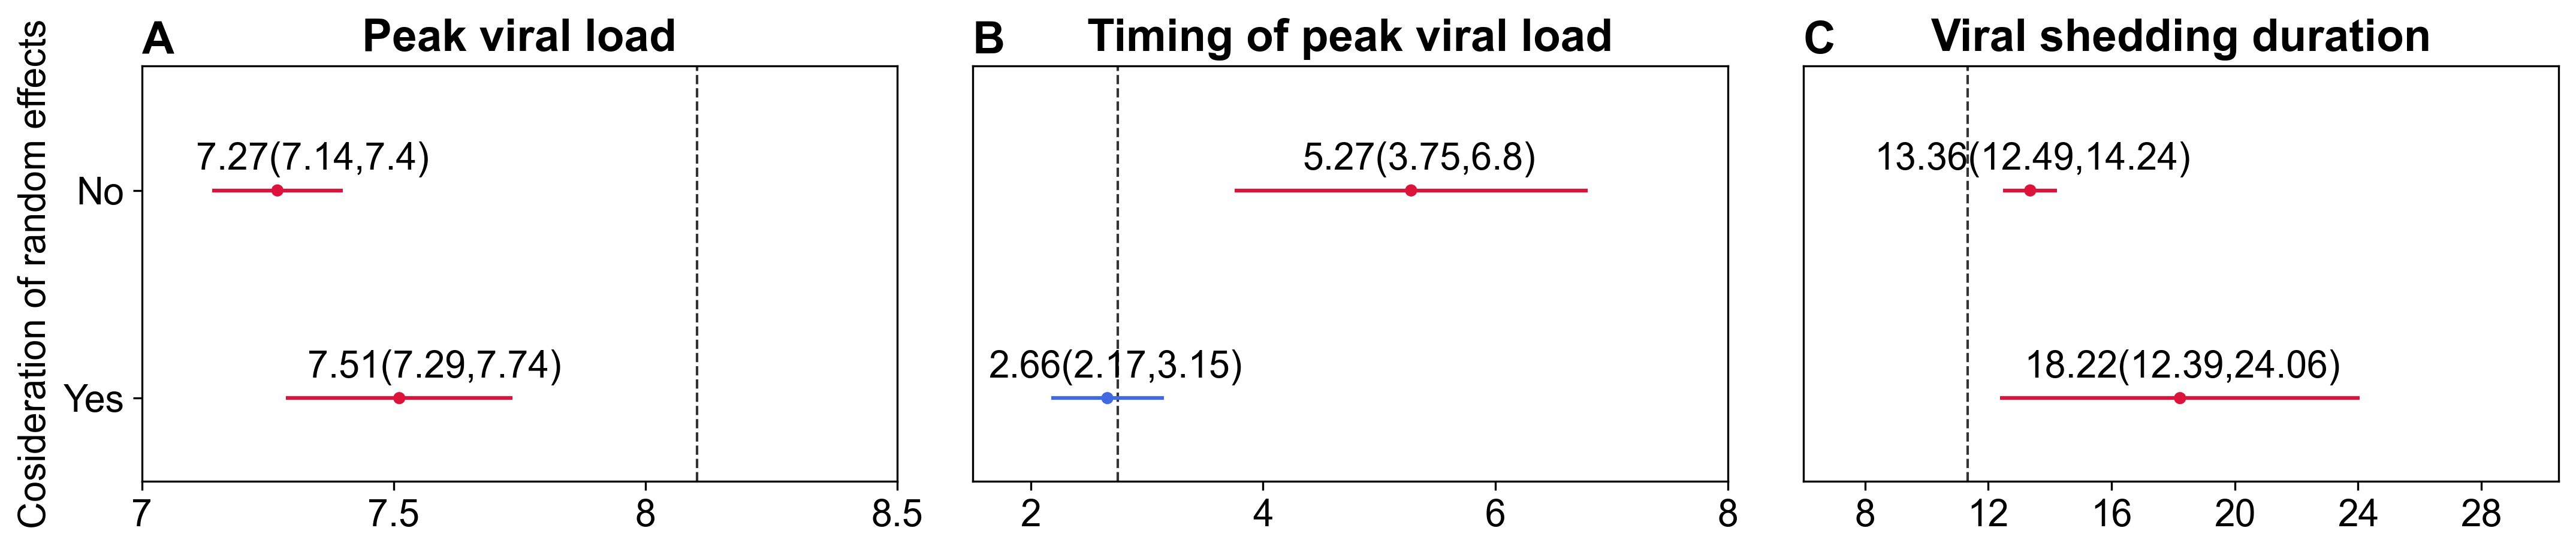

In [35]:
fig=plt.figure(figsize=(14,3),dpi=set_dpi)

gs[0]=fig.add_gridspec(nrows=1,ncols=1,left=0, right=0.3)
gs[1]=fig.add_gridspec(nrows=1,ncols=1,left=0.33, right=0.63)
gs[2]=fig.add_gridspec(nrows=1,ncols=1,left=0.66, right=0.96)

# peaksize
i=0
metric=metrics[i]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df[metric][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.07, result_df["index"][j]-0.1, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[i], weight="bold", fontsize=18)
ax[i].set_xlim(7, 8.5)
ax[i].set_xticks([7, 7.5, 8, 8.5])
ax[i].set_xticklabels([7, 7.5, 8, 8.5], fontsize=15)
ax[i].set_yticks(result_df["index"])
ax[i].set_yticklabels([result_df['consider'][0], result_df['consider'][1]], fontsize=15)
ax[i].set_ylabel(y_title, fontsize=15)

#peaktime
i=1
metric=metrics[i]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df[metric][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.07, result_df["index"][j]-0.1, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[i], weight="bold", fontsize=18)
ax[i].set_xlim(1.5,8)
ax[i].set_xticks([2, 4, 6, 8])
ax[i].set_xticklabels([2, 4, 6, 8], fontsize=15)
ax[i].set_yticks([])

#duration
i=2
metric=metrics[i]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df[metric][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.07, result_df["index"][j]-0.1, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[i], weight="bold", fontsize=18)
ax[i].set_xlim(6, 30.5)
ax[i].set_xticks([8, 12, 16, 20, 24, 28])
ax[i].set_xticklabels([8, 12, 16, 20, 24, 28], fontsize=15)
ax[i].set_yticks([])


for i in range(3):
    ax[i].margins(x=0)
    ax[i].set_ylim(2.4,0.4)
    ax[i].grid(False)
    ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=18)


plt.show()

# fig.savefig(figurefolder+'FigS5.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# fig.savefig(figurefolder+'FigS5.png', format='png', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)

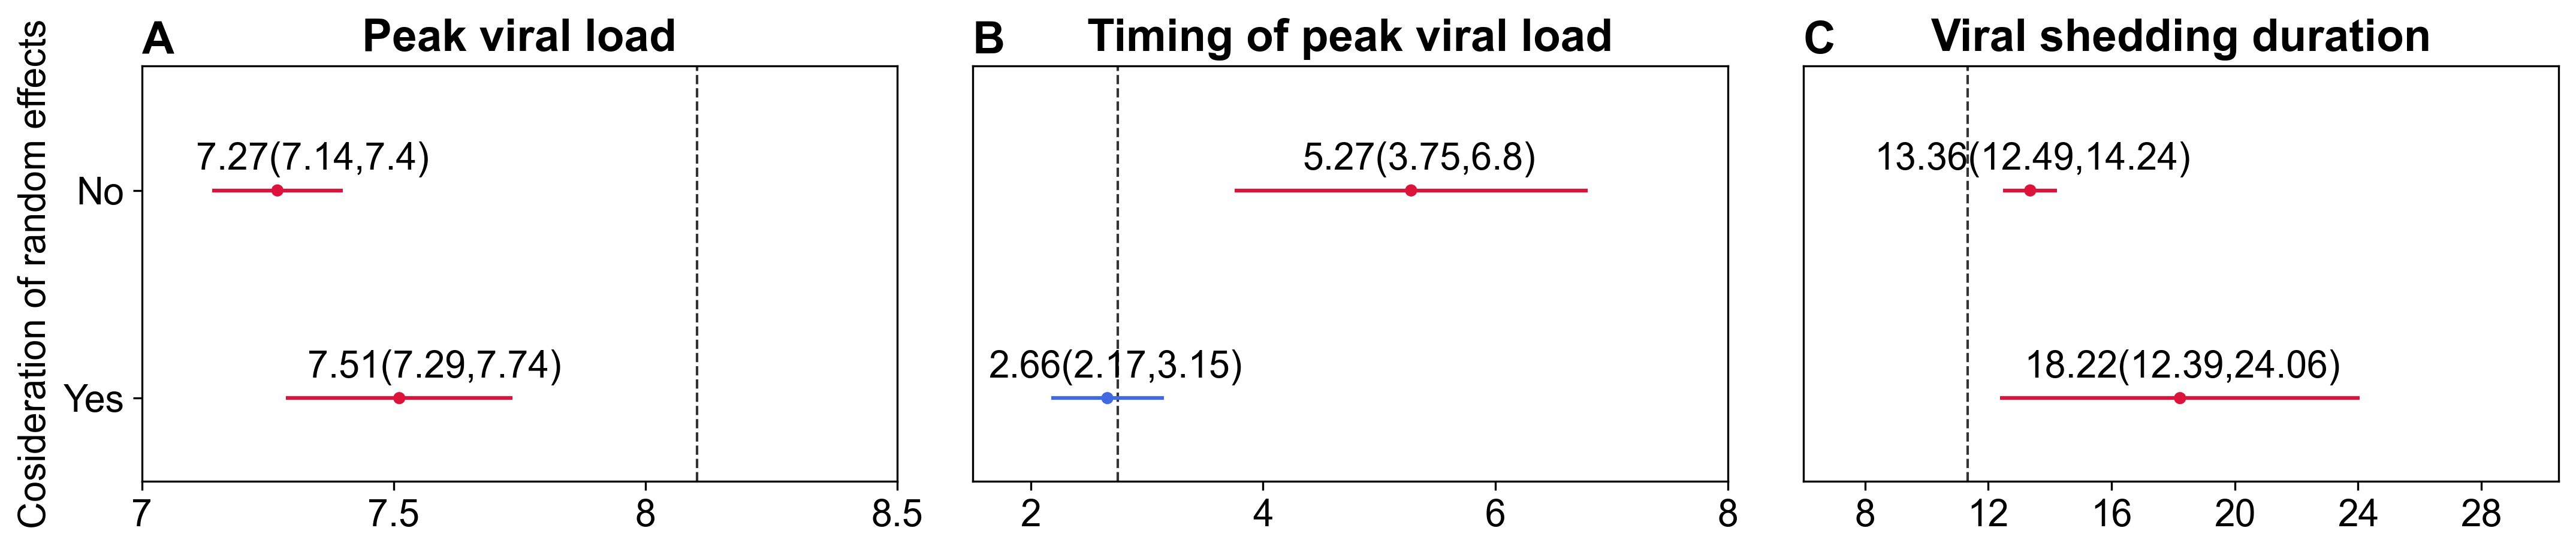

In [36]:
fig=plt.figure(figsize=(14,3),dpi=set_dpi)

gs[0]=fig.add_gridspec(nrows=1,ncols=1,left=0, right=0.3)
gs[1]=fig.add_gridspec(nrows=1,ncols=1,left=0.33, right=0.63)
gs[2]=fig.add_gridspec(nrows=1,ncols=1,left=0.66, right=0.96)

# peaksize
i=0
metric=metrics[i]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df[metric][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.07, result_df["index"][j]-0.1, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[i], weight="bold", fontsize=18)
ax[i].set_xlim(7, 8.5)
ax[i].set_xticks([7, 7.5, 8, 8.5])
ax[i].set_xticklabels([7, 7.5, 8, 8.5], fontsize=15)
ax[i].set_yticks(result_df["index"])
ax[i].set_yticklabels([result_df['consider'][0], result_df['consider'][1]], fontsize=15)
ax[i].set_ylabel(y_title, fontsize=15)

#peaktime
i=1
metric=metrics[i]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df[metric][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.07, result_df["index"][j]-0.1, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[i], weight="bold", fontsize=18)
ax[i].set_xlim(1.5,8)
ax[i].set_xticks([2, 4, 6, 8])
ax[i].set_xticklabels([2, 4, 6, 8], fontsize=15)
ax[i].set_yticks([])

#duration
i=2
metric=metrics[i]
ax[i]=fig.add_subplot(gs[i][0])
ax[i].scatter(x=metric, y="index", data=result_df, color=result_df[metric+'_color'], s=15)
ax[i].axvline(x=true_df[metric][0], color='black', alpha=0.8, linestyle='dashed', linewidth=1)
for j in range(len(result_df[metric])):
    ax[i].errorbar(x=result_df[metric][j], y=result_df["index"][j],
                   xerr=[[result_df[metric][j]-result_df[f"{metric}_lower"][j]], [result_df[f"{metric}_upper"][j]-result_df[metric][j]]],
                   fmt='none', ecolor=result_df[metric+'_color'][j], capsize=0)
    ax[i].text(result_df[metric][j]+0.07, result_df["index"][j]-0.1, 
               str(round(result_df[metric][j],2))+"("+str(round(result_df[f"{metric}_lower"][j],2))+","+str(round(result_df[f"{metric}_upper"][j],2))+")", ha='center', color="black", fontsize=15)
ax[i].set_title(titles[i], weight="bold", fontsize=18)
ax[i].set_xlim(6, 30.5)
ax[i].set_xticks([8, 12, 16, 20, 24, 28])
ax[i].set_xticklabels([8, 12, 16, 20, 24, 28], fontsize=15)
ax[i].set_yticks([])


for i in range(3):
    ax[i].margins(x=0)
    ax[i].set_ylim(2.4,0.4)
    ax[i].grid(False)
    ax[i].text(0,1.03,'{}'.format(string.ascii_uppercase[i]),transform=ax[i].transAxes,weight='bold',fontsize=18)


plt.show()

# fig.savefig(figurefolder+'FigS5.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# fig.savefig(figurefolder+'FigS5.png', format='png', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)

# Fig S6.

In [37]:
# Test cases
S_list = [3]
U_list = [1, 2, 3, 4, 5, 8]
M_test_list = [200, 500, 1000]

# Read true values
score_df_1 = pd.read_csv(os.path.join(inputfolder, "Coveragescore_"+str(M_test_list[0])+"_S"+str(S_list[0])+".csv"), index_col=0)
score_df_2 = pd.read_csv(os.path.join(inputfolder, "Coveragescore_"+str(M_test_list[1])+"_S"+str(S_list[0])+".csv"), index_col=0)
score_df_3 = pd.read_csv(os.path.join(inputfolder, "Coveragescore_"+str(M_test_list[2])+"_S"+str(S_list[0])+".csv"), index_col=0)

score_df_1

time    M1    M2    M3    M4    M5   M8
1      0.00  1.00  1.00  1.00  1.00  1.00  1.0
2      0.01  0.08  0.95  0.96  0.96  0.95  0.9
3      0.02  0.08  0.95  0.96  0.96  0.95  0.9
4      0.03  0.08  0.95  0.96  0.96  0.95  0.9
5      0.04  0.08  0.95  0.96  0.96  0.95  0.9
...     ...   ...   ...   ...   ...   ...  ...
2997  29.96  0.07  0.93  1.00  1.00  1.00  1.0
2998  29.97  0.07  0.93  1.00  1.00  1.00  1.0
2999  29.98  0.07  0.93  1.00  1.00  1.00  1.0
3000  29.99  0.07  0.93  1.00  1.00  1.00  1.0
3001  30.00  0.07  0.93  1.00  1.00  1.00  1.0

[3001 rows x 7 columns]

In [ ]:
## boxplot
timephase_start=[0.00, 2.00, 8.00]

def timephase(df):
    df2=df[df['time']<=15]
    
    df2['timephase']='3'
    df2.loc[df2['time'] < timephase_start[2], 'timephase'] = '2'
    df2.loc[df2['time'] < timephase_start[1], 'timephase'] = '1'
    df2 = df2.drop(['time', 'M5', 'M8'], axis=1)
    
    return(df2)
    

In [ ]:
score_df1 = timephase(score_df_1)
score_df2 = timephase(score_df_2)
score_df3 = timephase(score_df_3)

group_score1 = score_df1.melt(id_vars='timephase', var_name='u', value_name='score')
group_score2 = score_df2.melt(id_vars='timephase', var_name='u', value_name='score')
group_score3 = score_df3.melt(id_vars='timephase', var_name='u', value_name='score')

group_score1

timephase   u  score
0            1  M1   1.00
1            1  M1   0.08
2            1  M1   0.08
3            1  M1   0.08
4            1  M1   0.08
...        ...  ..    ...
5999         3  M4   1.00
6000         3  M4   1.00
6001         3  M4   1.00
6002         3  M4   1.00
6003         3  M4   1.00

[6004 rows x 3 columns]

In [41]:
ax=[0]*3
gs=[0]*3

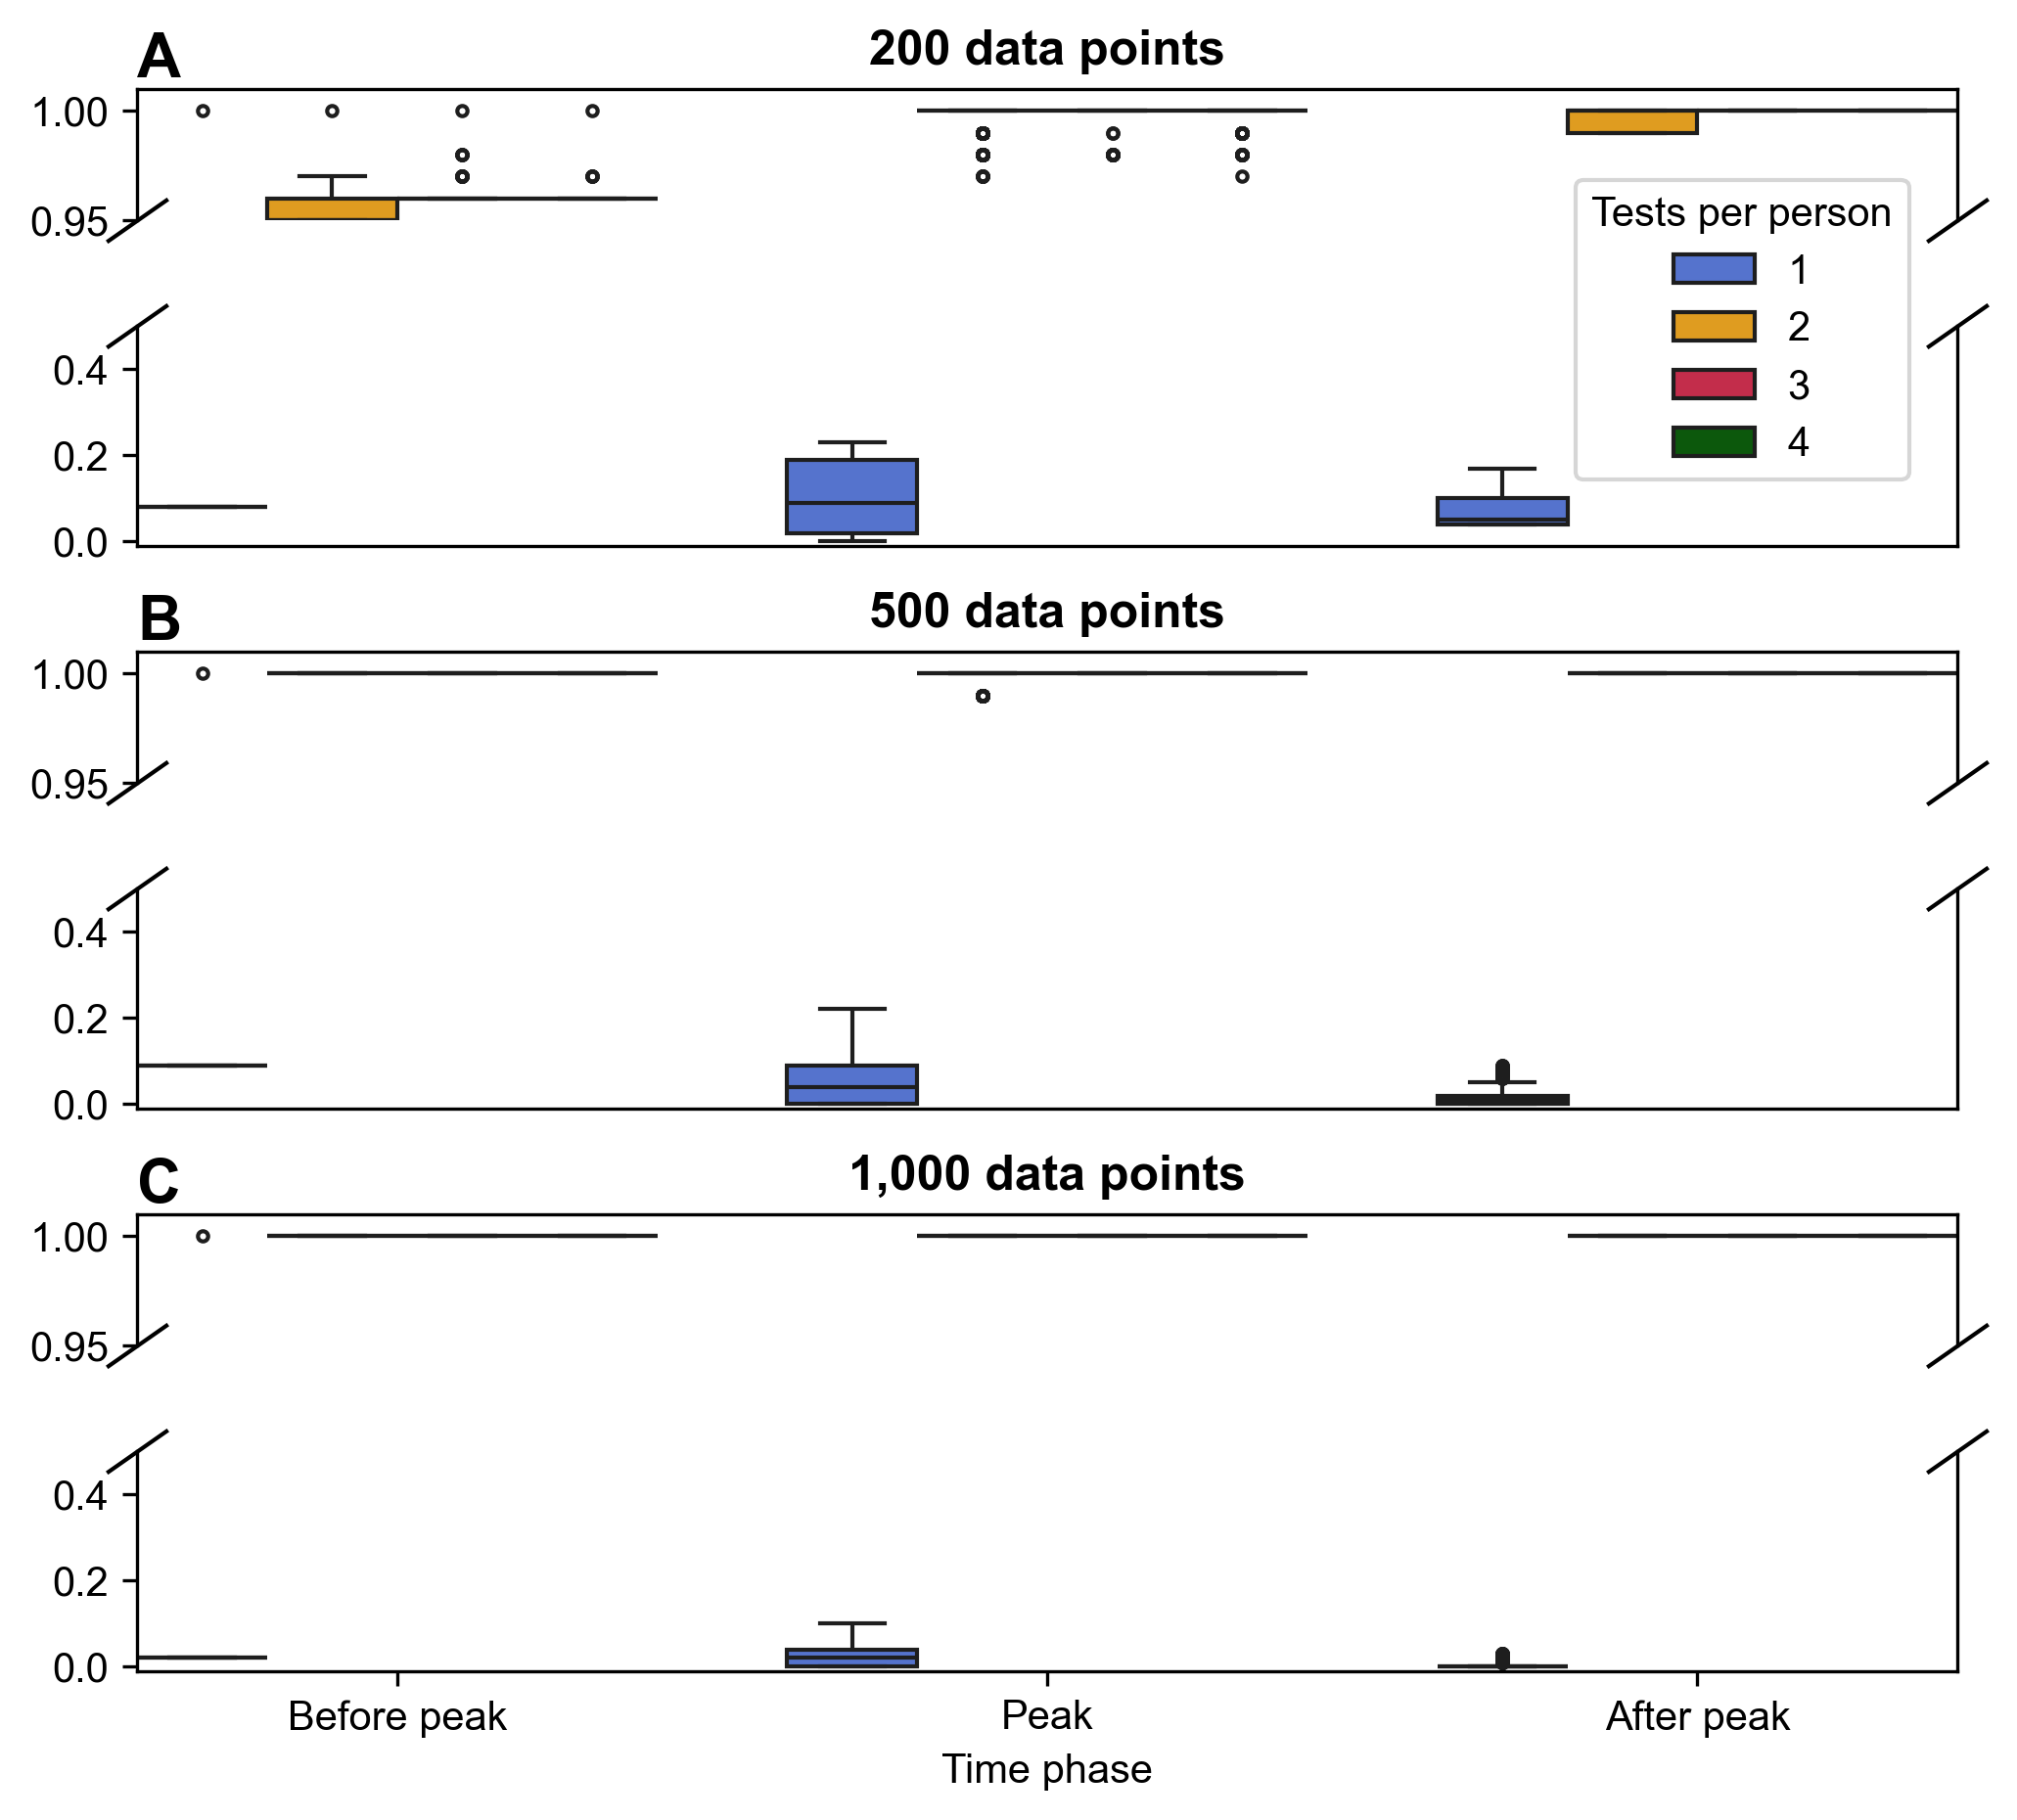

In [ ]:
custom_palette = {"M1": "royalblue", "M2": "orange", "M3": "crimson", "M4": "darkgreen"}

fig = plt.figure(figsize=(8, 7), dpi=set_dpi)
gs = gridspec.GridSpec(6, 1, figure=fig, height_ratios=[3, 5, 3, 5, 3, 5], hspace=0.6)

ax1_top = fig.add_subplot(gs[0, 0])
ax1_bottom = fig.add_subplot(gs[1, 0], sharex=ax1_top) 

ax2_top = fig.add_subplot(gs[2, 0], sharex=ax1_top) 
ax2_bottom = fig.add_subplot(gs[3, 0], sharex=ax1_top) 

ax3_top = fig.add_subplot(gs[4, 0], sharex=ax1_top) 
ax3_bottom = fig.add_subplot(gs[5, 0], sharex=ax1_top) 

ax_pairs = [(ax1_top, ax1_bottom), (ax2_top, ax2_bottom), (ax3_top, ax3_bottom)]
scenario_info = [
    {'data': group_score1, 'title': '200 data points'},
    {'data': group_score2, 'title': '500 data points'}, 
    {'data': group_score3, 'title': '1,000 data points'}
]

ylim_upper = (0.95, 1.01) 
ylim_lower = (-0.01, 0.5)  
d = .7 
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15, linestyle="none", color='k', clip_on=False)

for i, ((ax_top, ax_bottom), info) in enumerate(zip(ax_pairs, scenario_info)):
    data = info['data']
    title = info['title']
    ax_top.set_ylim(ylim_upper)
    ax_bottom.set_ylim(ylim_lower)
    ax_top.spines['bottom'].set_visible(False)
    ax_bottom.spines['top'].set_visible(False)
    ax_top.xaxis.set_visible(False)
    ax_top.plot([0, 1], [0, 0], transform=ax_top.transAxes, **kwargs)
    ax_bottom.plot([0, 1], [1, 1], transform=ax_bottom.transAxes, **kwargs)

    sns.boxplot(data=data, x='timephase', y='score', hue='u', ax=ax_top, palette=custom_palette, showfliers=True, flierprops=dict(marker='.', color='gray', markersize=5))
    sns.boxplot(data=data, x='timephase', y='score', hue='u', ax=ax_bottom, palette=custom_palette, showfliers=True, flierprops=dict(marker='.', color='gray', markersize=5))

    ax_top.set_title(title, weight='bold')
    ax_top.text(0, 1.43, '{}'.format(string.ascii_uppercase[i]), transform=ax_top.transAxes, weight='bold', fontsize=15, va='top', ha='left')
    ax_bottom.set_yticks([0, 0.2, 0.4])
    if i == 0:
        handles, labels = ax_top.get_legend_handles_labels()
        new_labels = ["1", "2", "3", "4"]
        ax_bottom.legend(handles[:4], new_labels, title="Tests per person", loc=(0.79, 0.3))
    else:
        ax_bottom.legend().remove()
    ax_top.legend().remove()
    ax_top.set_ylabel("")
    ax_bottom.set_ylabel("")
    if i < len(ax_pairs) - 1:
        ax_bottom.xaxis.set_visible(False)
    else:
        ax_bottom.set_xticks([0, 1, 2]) # assuming 'Before peak', 'Peak', 'After peak' map to 0, 1, 2
        ax_bottom.set_xticklabels(['Before peak', 'Peak', 'After peak'])
        ax_bottom.set_xlabel("Time phase")
    ax_top.margins(x=0)
    ax_bottom.margins(x=0)


plt.tight_layout() 
plt.show()


# fig.savefig(figurefolder+'FigS6.tiff', format='tiff', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)
# fig.savefig(figurefolder+'FigS6.png', format='png', bbox_inches='tight', pad_inches=.1, dpi=set_dpi)